In [1]:
import os, sys, time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow.keras
import konlpy
from konlpy.tag import Komoran, Mecab, Okt, Twitter
%matplotlib inline
print('konlpy version = {}'.format(konlpy.__version__))

from IPython.display import SVG
from keras.utils import model_to_dot
# SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

konlpy version = 0.5.2


/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aicoe/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [2]:
dataset = pd.read_csv('total_dataset.csv', index_col = False)

In [3]:
dataset = dataset.sample(frac = 1).reset_index(drop = True)

In [4]:
data_split_ratio = 0.8
train_data = dataset[:round(dataset.shape[0]*data_split_ratio)]
test_data = dataset[round(dataset.shape[0]*data_split_ratio):]

In [5]:
train_data['rank'].value_counts()

1    21897
0    21855
Name: rank, dtype: int64

In [6]:
test_data['rank'].value_counts()

0    5492
1    5446
Name: rank, dtype: int64

In [7]:
del dataset

In [8]:
train_data['contents'] = train_data['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['contents'] = test_data['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [9]:
train_data.drop(train_data[train_data.contents == ' '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '  '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '   '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '    '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '     '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '      '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '       '].index, inplace=True)
train_data.drop(train_data[train_data.contents == '        '].index, inplace=True)

In [10]:
test_data.drop(test_data[test_data.contents == ' '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '  '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '   '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '    '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '     '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '      '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '       '].index, inplace=True)
test_data.drop(test_data[test_data.contents == '        '].index, inplace=True)

In [11]:
train_data.dropna(subset = ['contents'], inplace = True)
test_data.dropna(subset = ['contents'], inplace = True)

In [12]:
# ko_tokenizer setup
ko_tokenizer = Komoran()
stopwords = ['']

In [13]:
# sentence word tokenizing for train_data
s = time.time()
x_train = []
for i, sentence in enumerate(train_data['contents']):
    temp_X = []
    temp_X = list(ko_tokenizer.morphs(sentence)) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]
    x_train.append(temp_X)
print('train sentence word tokenizing time = {:.3f}'.format(time.time() - s))

train sentence word tokenizing time = 38.996


In [14]:
x_train[0]

['저렴',
 '하',
 'ㄴ',
 '가격',
 '에',
 '구매',
 '하',
 'ㄹ',
 '수',
 '있',
 '어',
 '와',
 'ㄴ',
 '전조',
 '아',
 '요']

In [15]:
# sentensce word tokenizing for test_data
s = time.time()
x_test =[]
for i, sentence in enumerate(test_data['contents']):
    temp_x = []
    temp_x = list(ko_tokenizer.morphs(sentence))
    temp_x = [word for word in temp_x if not word in stopwords]
    x_test.append(temp_x)
print('test sentence word tokenizing time = {:.3f}'.format(time.time()-s))

test sentence word tokenizing time = 9.846


In [16]:
# 띄어쓰기한 train contents로 변환
tmp_train = []
for sentence in x_train:
    tmp_x = ' '.join(sentence)
    tmp_train.append(tmp_x)

train_data['contents'] = tmp_train

In [17]:
# 띄어쓰기한 train contents로 변환
tmp_test = []
for sentence in x_test:
    tmp_x = ' '.join(sentence)
    tmp_test.append(tmp_x)

test_data['contents'] = tmp_test

In [18]:
# word를 index vector로 변환
from tensorflow.keras.preprocessing.text import Tokenizer
t= Tokenizer()
t.fit_on_texts(train_data['contents'])
vocab_size = len(t.word_index)+1
print('vocab_size = {}'.format(vocab_size))

vocab_size = 24552


In [19]:
s = time.time()
train_sent_onehot = t.texts_to_sequences(train_data['contents'])
print('train_sent_onehot generation time = {:.2f}'.format(time.time()-s))

train_sent_onehot generation time = 0.94


In [20]:
s = time.time()
test_sent_onehot = t.texts_to_sequences(test_data['contents'])
print('test_sent_onehot generation time = {:.2f}'.format(time.time()-s))

test_sent_onehot generation time = 0.21


max length of contents :  1140
average length of contents :  34.080350203447175


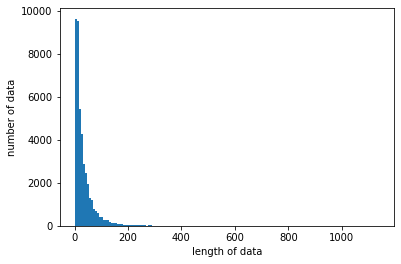

In [21]:
print('max length of contents : ', max(len(l) for l in x_train))
print('average length of contents : ', sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins =150)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train_sent_onehot, maxlen = 300, padding = 'pre')
x_test = pad_sequences(test_sent_onehot, maxlen = 300, padding = 'pre')
y_train = train_data['rank'].to_numpy()
y_test = test_data['rank'].to_numpy()

In [23]:
x_train

array([[   0,    0,    0, ..., 4788,   16,   32],
       [   0,    0,    0, ...,  373,  203,    9],
       [   0,    0,    0, ...,  341,  292,    3],
       ...,
       [   0,    0,    0, ...,  153,   19,   29],
       [   0,    0,    0, ...,   48,  386,   26],
       [   0,    0,    0, ...,   67,    8,   98]], dtype=int32)

In [39]:
import argparse
# import tensorflow.keras
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dot, Activation, Reshape, TimeDistributed, Permute, Input, Dense, Conv1D, LSTM, GRU, Bidirectional, Embedding, Dropout, concatenate, Flatten, Activation, MaxPooling1D, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import multi_gpu_model

In [49]:
def build_bdlstm_1layer_model(args):
    inputs = Input(shape=(args.max_length,))
    if args.embedding_matrix is None:
        output = Embedding(vocab_size, args.embedding_dim, trainable = True)(inputs)
    else:
        output = Embedding(vocab_size, args.embedding_dim, trainable = False, weights=[embedding_matrix])(inputs)    
#     output = Embedding(vocab_size, 300, input_length=args.max_length)(inputs)
    output = Bidirectional(LSTM(100, return_sequences = True, dropout = args.dropout, recurrent_dropout = 0.1))(output)
    output = GlobalMaxPool1D()(output)
    output = Dense(100, activation = args.activation,kernel_regularizer=regularizers.l2(1e-4))(output)
    output = Dropout(args.dropout)(output)
    preds = Dense(1, activation = 'sigmoid')(output)
    model = Model(inputs, preds)
#     try:
#         model = multi_gpu_model(model, cpu_relocation = True)
# #         model = multi_gpu_model(model, gpus = 2, cpu_relocation = True)
#         print('#'*50)
#         print('====> training using multiple gpu')
#         print('#'*50)
#     except:
#         print('#'*50)
#         print('====> training using single gpu or cpu')
#         print('#'*50)
    return model

def build_bdlstm_2layer_model(args):
    inputs = Input(shape=(args.max_length,))
    output = Embedding(vocab_size, args.embedding_dim, input_length=args.max_length)(inputs)
    output = Bidirectional(LSTM(100, return_sequences = True, dropout = args.dropout, recurrent_dropout = 0.2))(output)
    output = Bidirectional(LSTM(100, return_sequences = True, dropout = args.dropout, recurrent_dropout = 0.2))(output)
    output = GlobalMaxPool1D()(output)
    output = Dense(100, activation = args.activation)(output)
    output = Dropout(args.dropout)(output)
    preds = Dense(1, activation = 'sigmoid')(output)
    model = Model(inputs, preds)
    try:
        model = multi_gpu_model(model, cpu_relocation = True)
# model = multi_gpu_model(model, gpus = 2, cpu_relocation = True)
        print('#'*50)
        print('====> training using multiple gpu')
        print('#'*50)
    except:
        print('#'*50)
        print('====> training using single gpu or cpu')
        print('#'*50)
    return model

def build_bdlstm_conv1d_model(args):
    inputs = Input(shape=(args.max_length, ))
    output = Embedding(vocab_size, args.embedding_dim, input_length=args.max_length)(inputs)
    output = SpatialDropout1D(0.2)(output)
    output = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(output)
    output = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(output)
    avg_pool = GlobalAveragePooling1D()(output)
    max_pool = GlobalMaxPooling1D()(output)
    output = concatenate([avg_pool, max_pool]) 
    output = Dense(64, activation=args.activation)(output)
    output = Dropout(0.1)(output)
    preds = Dense(1, activation="sigmoid")(output)
    model = Model(inputs, preds)
    try:
        model = multi_gpu_model(model, cpu_relocation = True)
    # model = multi_gpu_model(model, gpus = 2, cpu_relocation = True)
        print('#'*50)
        print('====> training using multiple gpu')
        print('#'*50)
    except:
        print('#'*50)
        print('====> training using single gpu or cpu')
        print('#'*50)
    return model


def build_bdlstm_attention_model(args):
    # Define input tensor
    inputs = Input(shape=(args.max_length, ))

    # Word embedding layer
    output = Embedding(vocab_size, args.embedding_dim, input_length=args.max_length)(inputs)

    # Apply dropout to prevent overfitting
    output = Dropout(0.2)(output)

    # Apply Bidirectional LSTM over embedded inputs
    output = Bidirectional(LSTM(100, return_sequences = True, dropout = args.dropout, recurrent_dropout = 0.2))(output)

    # Apply dropout to LSTM outputs to prevent overfitting
    output = Dropout(0.2)(output)    
    input_dim = int(output.shape[2])
    permuted_inputs = Permute((2, 1))(output)
    attention_vector = TimeDistributed(Dense(1))(output)
    attention_vector = Reshape((args.max_length,))(attention_vector)
    attention_vector = Activation('softmax', name='attention_vec')(attention_vector)
    attention_output = Dot(axes=1)([output, attention_vector])

    # Last layer: fully connected with softmax activation
    fc = Dense(100, activation=args.activation)(attention_output)
    preds = Dense(1, activation="sigmoid")(fc)

    # Finally building model
    model = Model(inputs, preds)
    
    return model


In [50]:
# result = model.evaluate(x_test, y_test, batch_size = 512)

In [51]:
# visualization
# Plot history: MAE
def visualization_training(history):
    plt.figure(figsize=(10,10))
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], marker = "o", label='BCE (testing data)')
    plt.plot(history.history['val_loss'], marker = "o",label='BCE (validation data)')
    plt.title('BCE monitor')
    plt.ylabel('BCE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    # plt.show()
    ax2 = plt.subplot(2, 1, 2)
    plt.plot(history.history['binary_accuracy'], marker = "o", label='Accuracy (testing data)')
    plt.plot(history.history['val_binary_accuracy'], marker = "o",label='Accuracy (validation data)')
    plt.title('Accuracy monitor')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [52]:
# from IPython.display import SVG
# from keras.utils import model_to_dot
# from keras.utils import plot_model


# # SVG(model_to_dot(model).create(prog='dot', format='svg'))

# args = argparse.ArgumentParser()
# # hyper parameter setup
# args.learner = 'adam'
# args.activation = 'relu'
# args.learning_rate = 0.001
# args.dropout = 0.3
# # args.max_length = max(len(l) for l in x_train)
# args.max_length = 300
# args.validation_split = 0.2
# args.epoch = 50
# args.train_batch_size = 512
# args.test_batch_size = 512
# args.embedding_matrix = None
# build_conv1d_model(args).summary()

# plot_model(build_conv1d_model(args), to_file='model.png')
# # SVG(model_to_dot(build_conv1d_model(args)).create(prog='dot', format='svg'))

In [53]:
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedir(model_dir)

In [54]:
checkpoint_path = 'model/cp_{}.ckpt'.format(time.strftime('%Y-%m-%d',time.localtime(time.time())))
checkpoint_dir = os.path.dirname(checkpoint_path)

In [55]:
# callback setup
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 4,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                 factor = 0.1,
                                 patience = 3,
                                 min_lr = 0.00001)

cp_callback = ModelCheckpoint(checkpoint_path,
                             save_weights_only = True,
                             save_best_only = True,
                             verbose = 1)

In [56]:
# args = argparse.ArgumentParser()
parser = argparse.ArgumentParser()
args = parser.parse_args("")
# hyper parameter setup
args.learner = 'adam'
args.activation = 'relu'
args.learning_rate = 0.001
args.dropout = 0.3
args.embedding_dim = 300
# args.max_length = max(len(l) for l in x_train)
args.max_length = 300
args.validation_split = 0.2
args.epoch = 20
args.verbose = 1
args.train_batch_size = 1024
args.test_batch_size = 512
args.embedding_matrix = None
args.model_name = 'bdlstm_1layer'
print(args)

def compile_model(args):
    if args.model_name == 'bdlstm_1layer':
        model = build_bdlstm_1layer_model(args)
    if args.model_name == 'bdlstm_2layer':
        model = build_bdlstm_2layer_model(args)
    if args.model_name == 'bdlstm_conv1d':
        model = build_bdlstm_conv1d_model(args)
    if args.model_name == 'bdlstm_attention':
        model = build_bdlstm_attention_model(args)        
    else : 
        print('model_name_argument : None, write the model_name')
#     print(model.summary())

    if args.learner.lower() == "adagrad":
        model.compile(optimizer=optimizers.Adagrad(lr=args.learning_rate),
                     loss=losses.binary_crossentropy,
                     metrics=[metrics.binary_accuracy])
    elif args.learner.lower() == "rmsprop":
        model.compile(optimizer=optimizers.RMSprop(lr=args.arglearning_rate),
                     loss=losses.binary_crossentropy,
                     metrics=[metrics.binary_accuracy])    
    elif args.learner.lower() == "adam":
        model.compile(optimizer=optimizers.Adam(lr=args.learning_rate),
                     loss=losses.binary_crossentropy,
                     metrics=[metrics.binary_accuracy])
    else:
        model.compile(optimizer=optimizers.SGD(lr=args.learning_rate),
                     loss=losses.binary_crossentropy,
                     metrics=[metrics.binary_accuracy])
    return model


Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)


Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)       

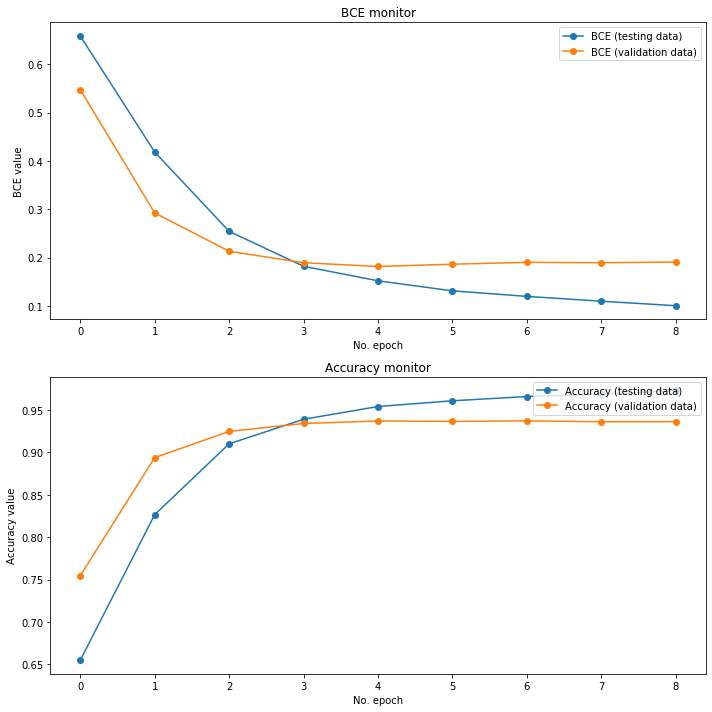

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)    

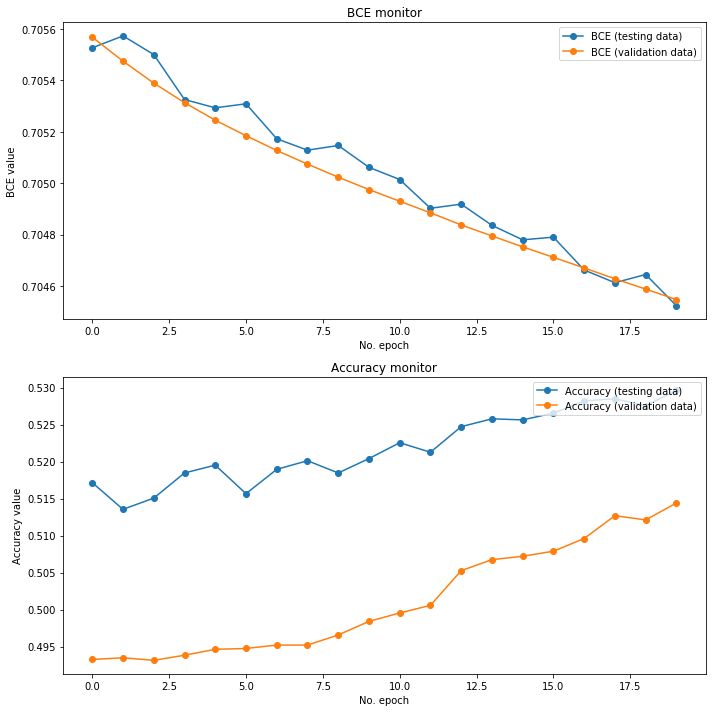

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)      

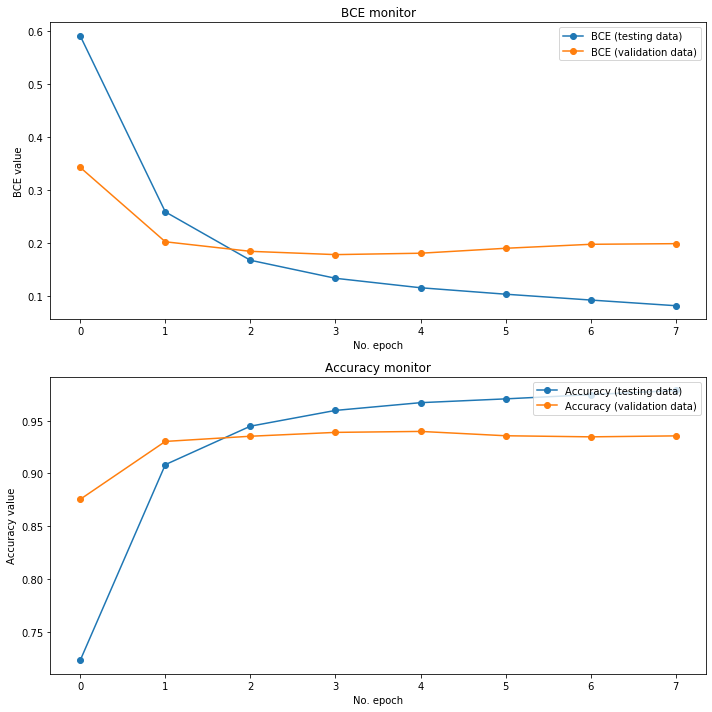

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)   

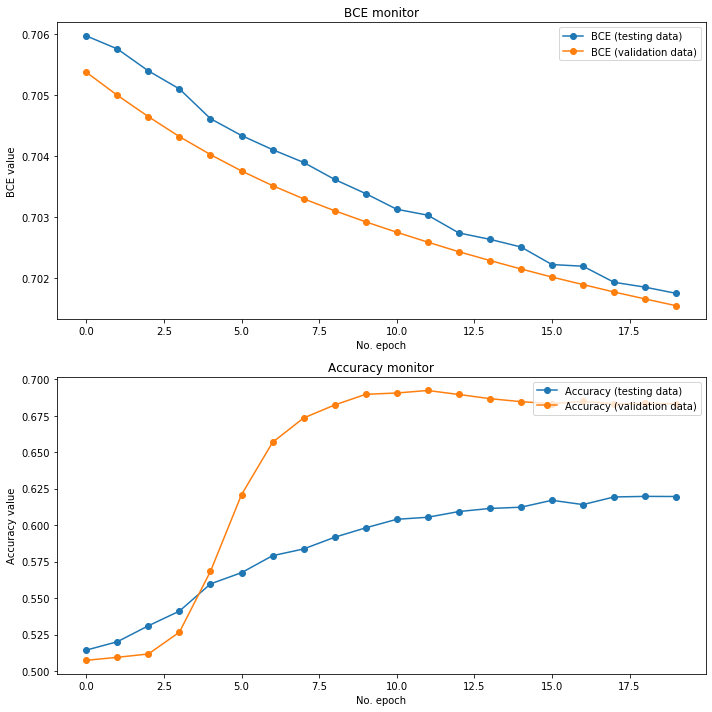

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)       

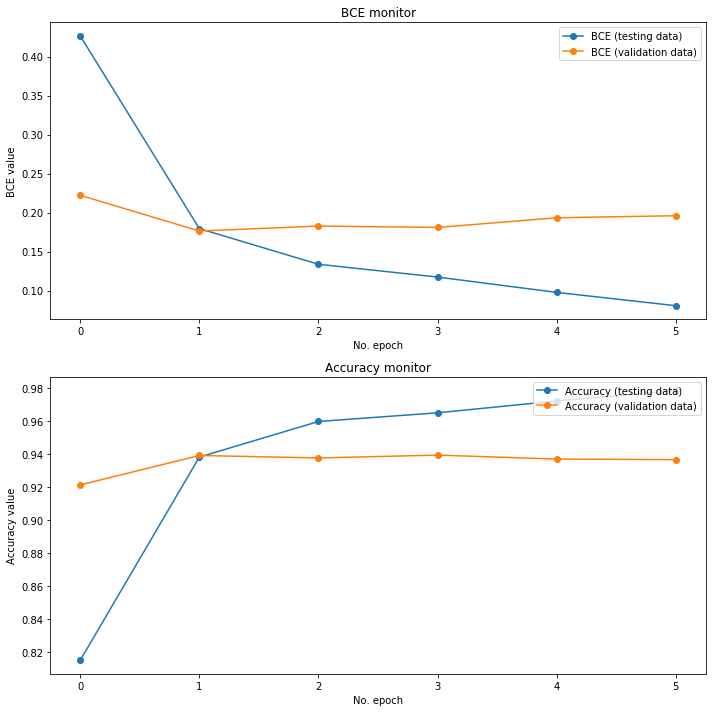

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)    

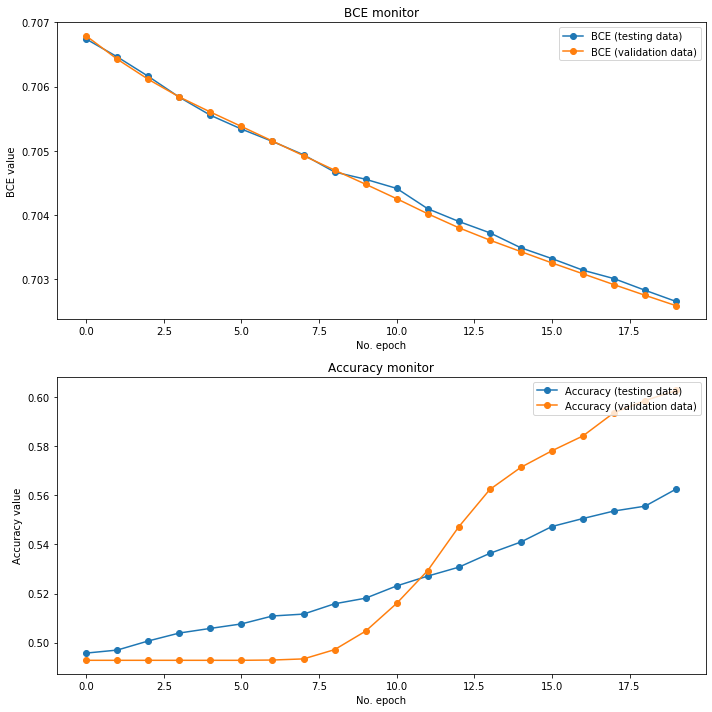

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 300, 200)          240800    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)      

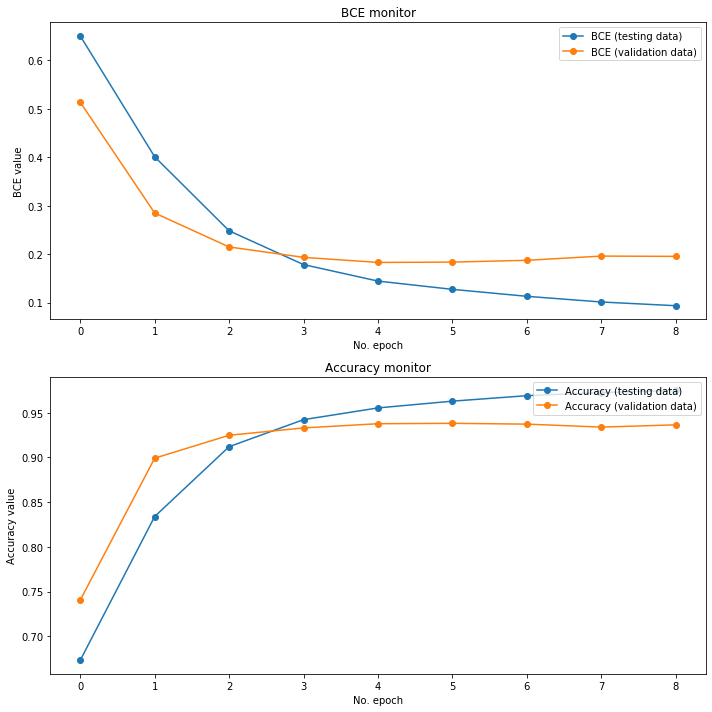

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)  

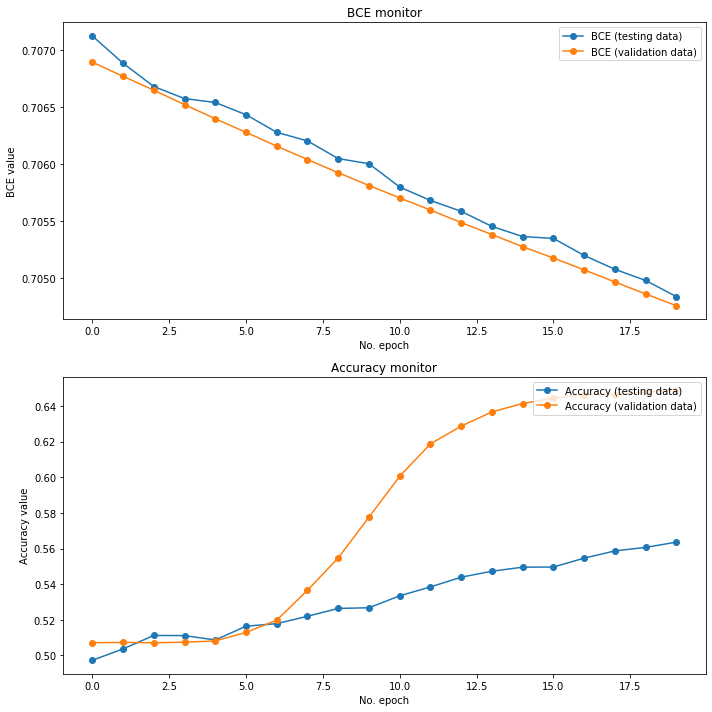

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)     

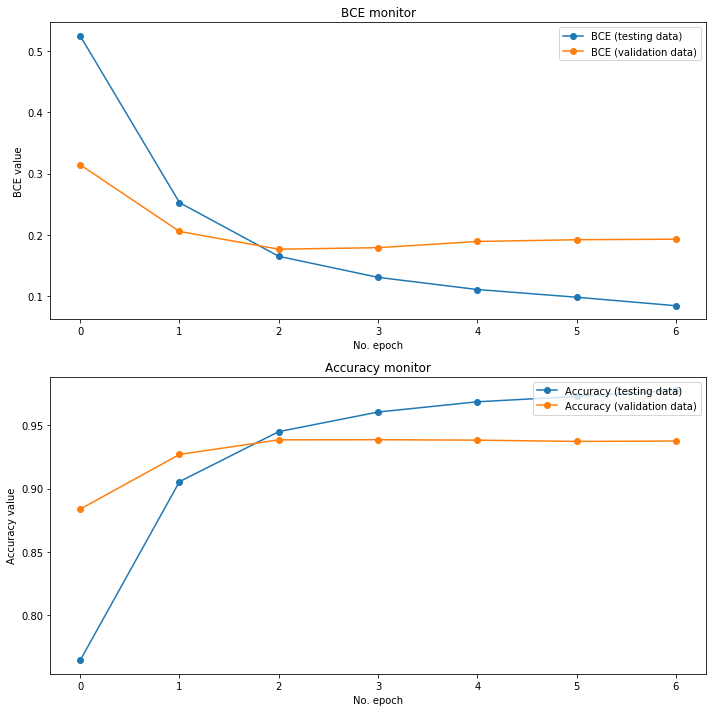

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)  

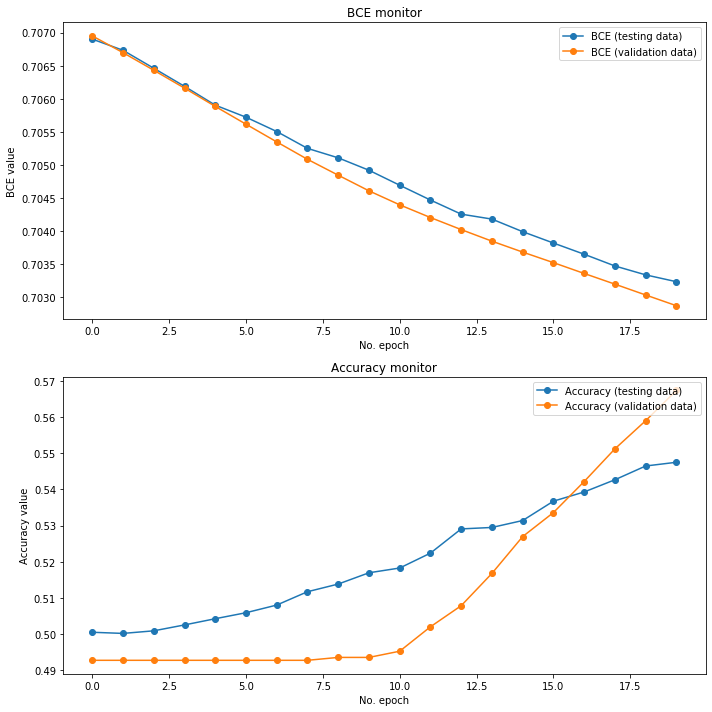

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)      

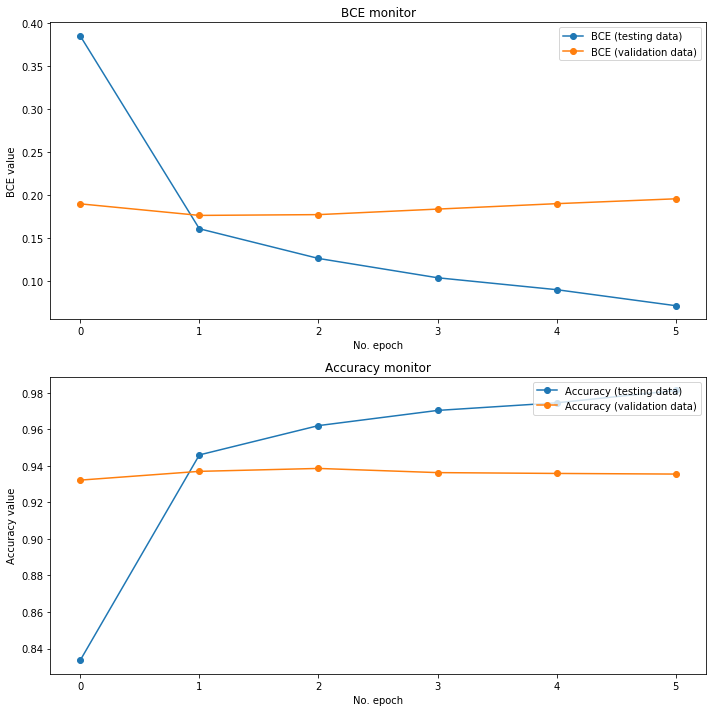

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)   

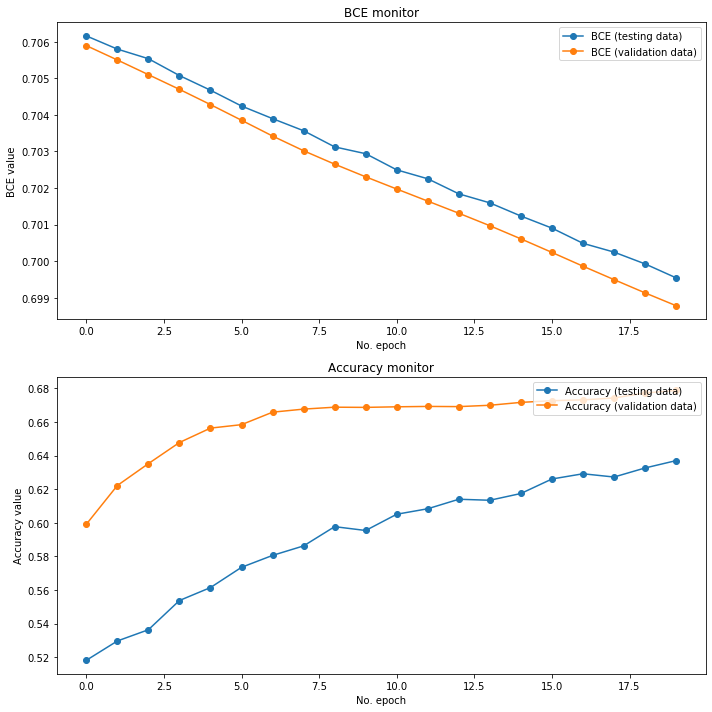

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)     

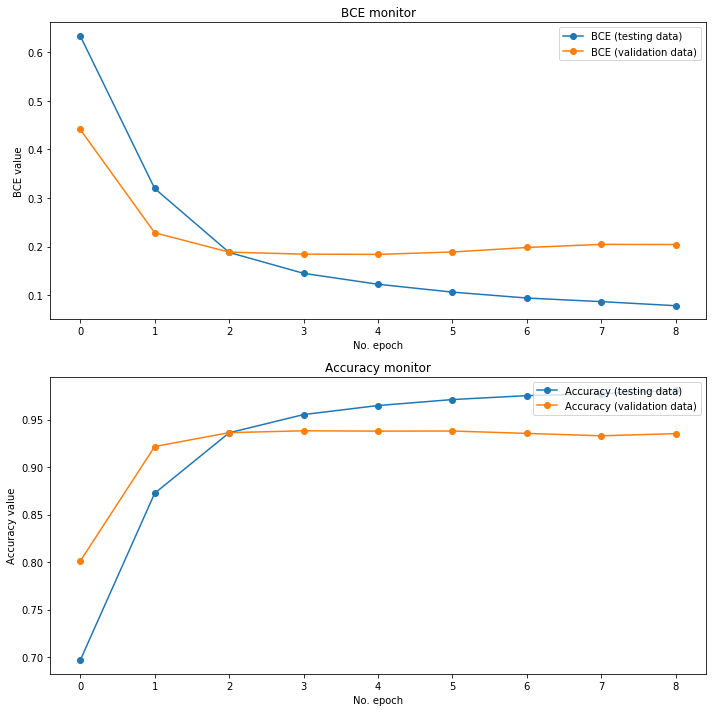

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)  

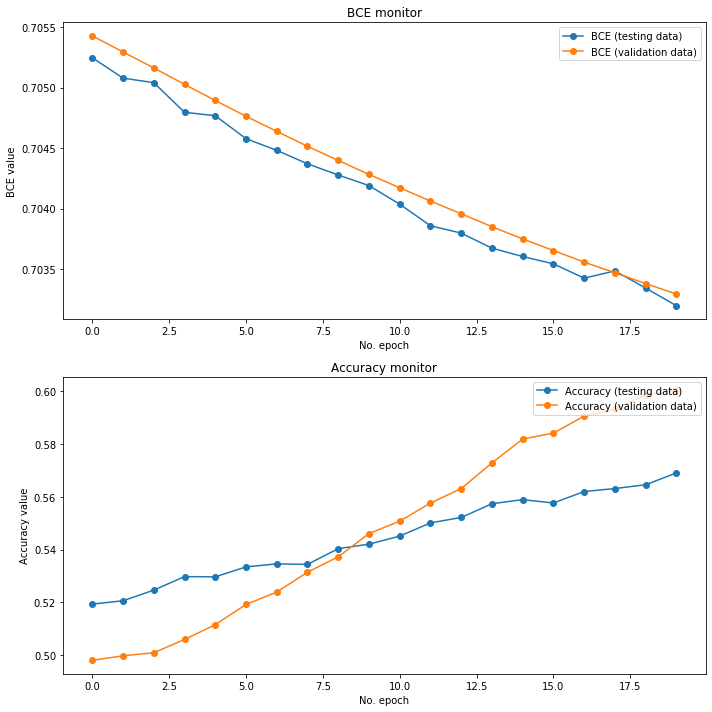

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)     

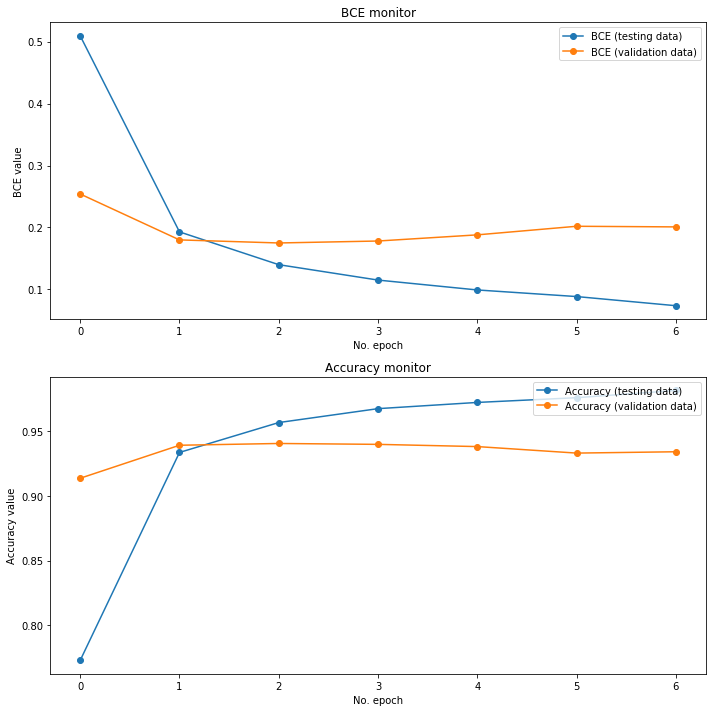

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)  

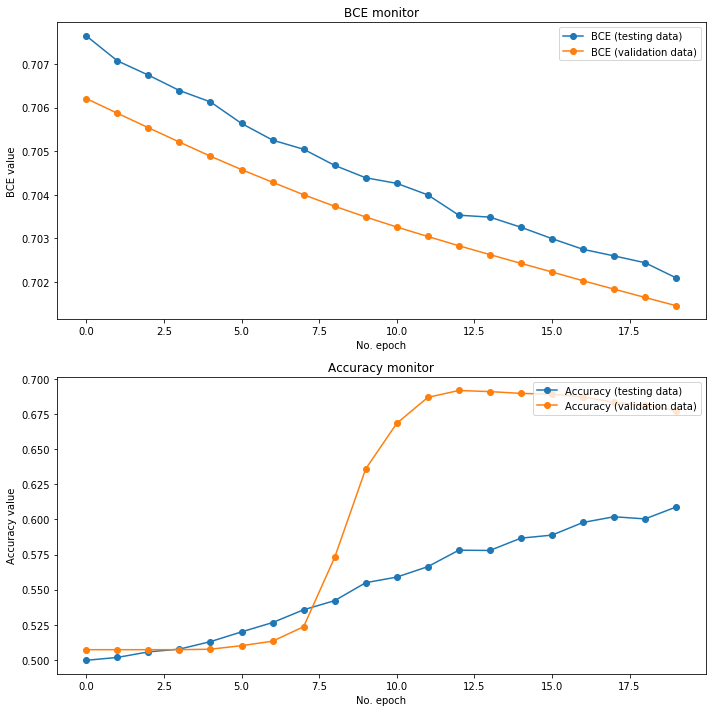

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)      

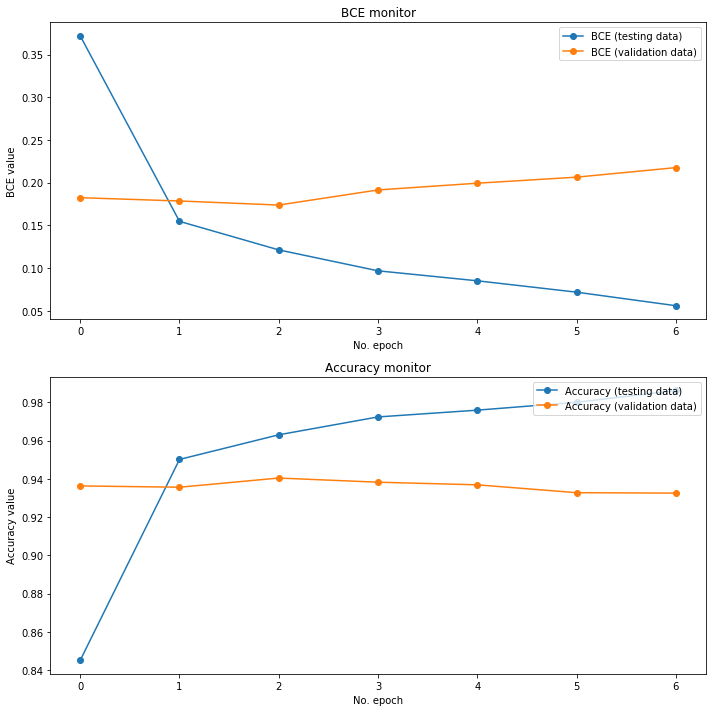

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_1layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
model_name_argument : None, write the model_name
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 200)               0         
_________________________________________________________________
dense_40 (Dense)   

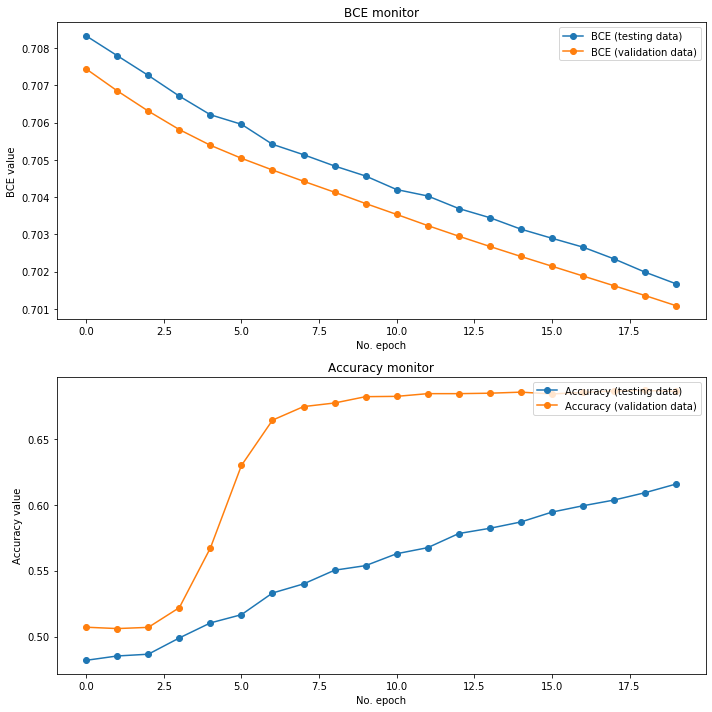

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 300, 200)          160800    
_________________________________________________________________
bidirectiona

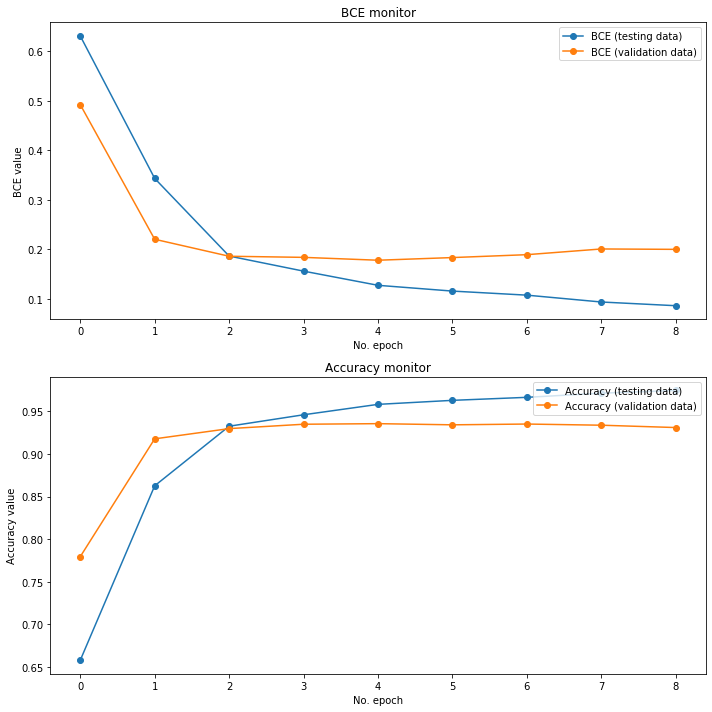

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 300, 200)          160800    
_________________________________________________________________
bidirecti

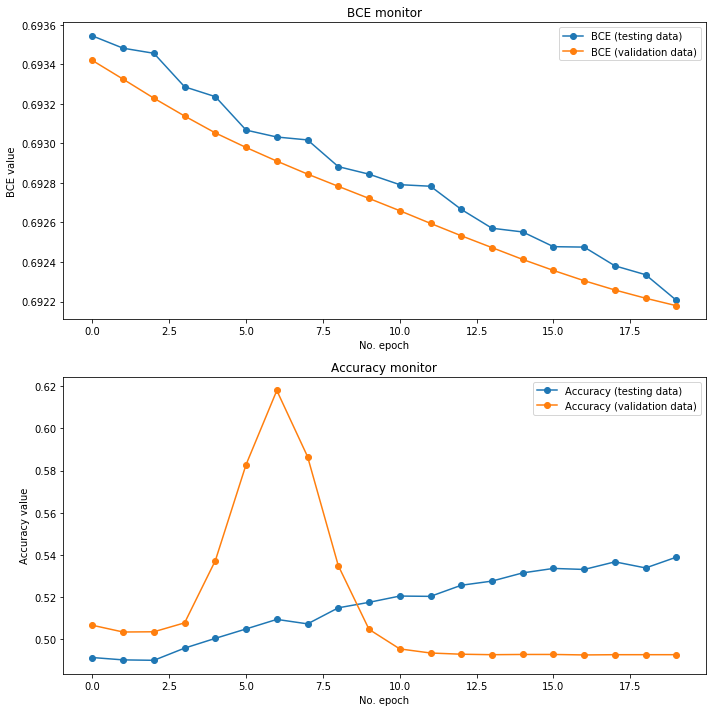

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 300, 200)          160800    
_________________________________________________________________
bidirectiona

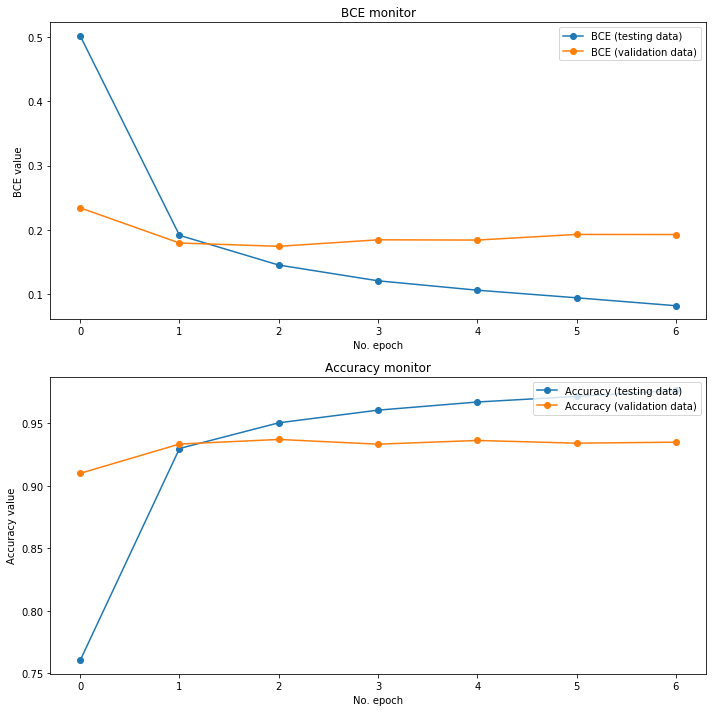

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 300, 200)          160800    
_________________________________________________________________
bidirecti

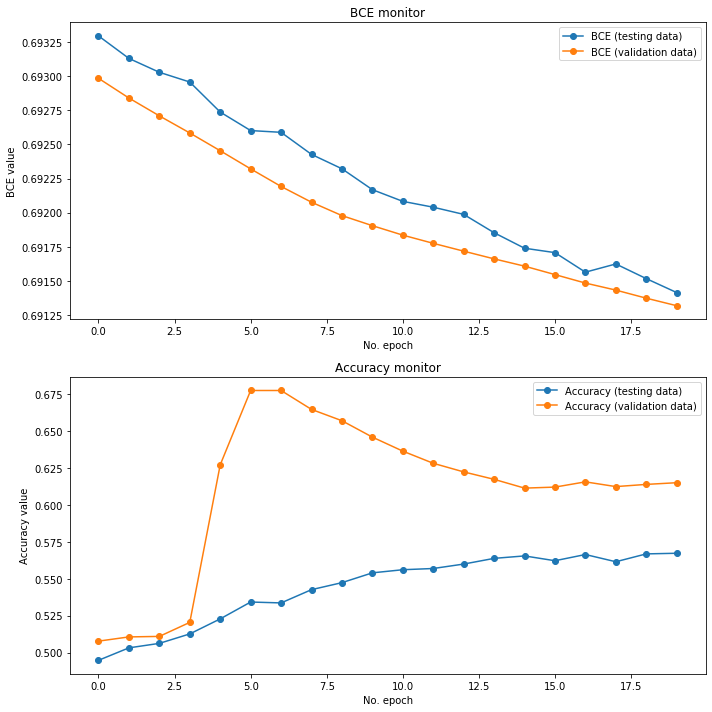

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 300, 200)          160800    
_________________________________________________________________
bidirectional

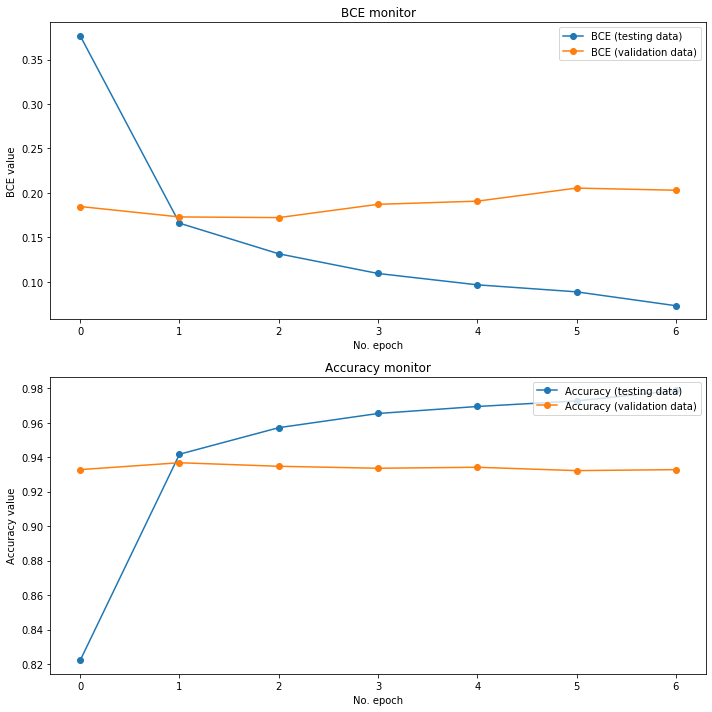

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 300, 100)          2455200   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 300, 200)          160800    
_________________________________________________________________
bidirectio

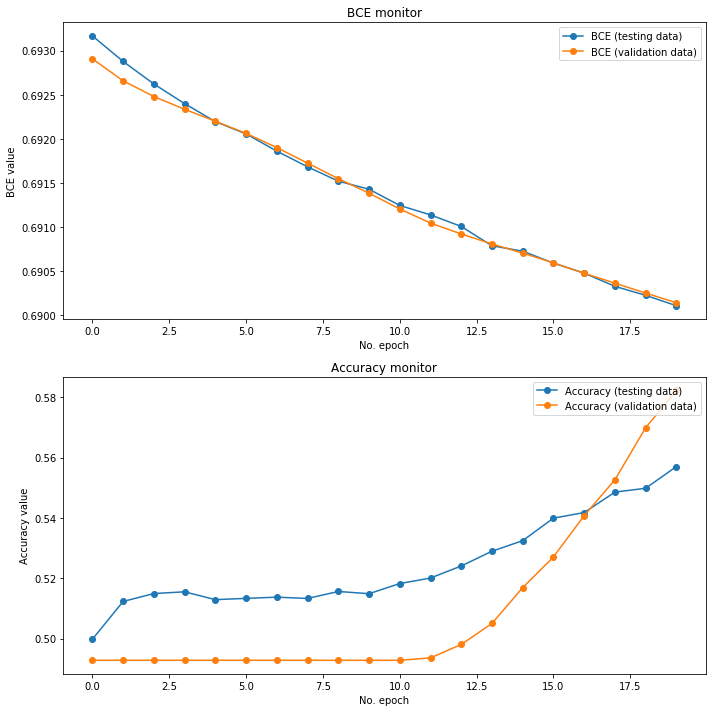

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
bidirectiona

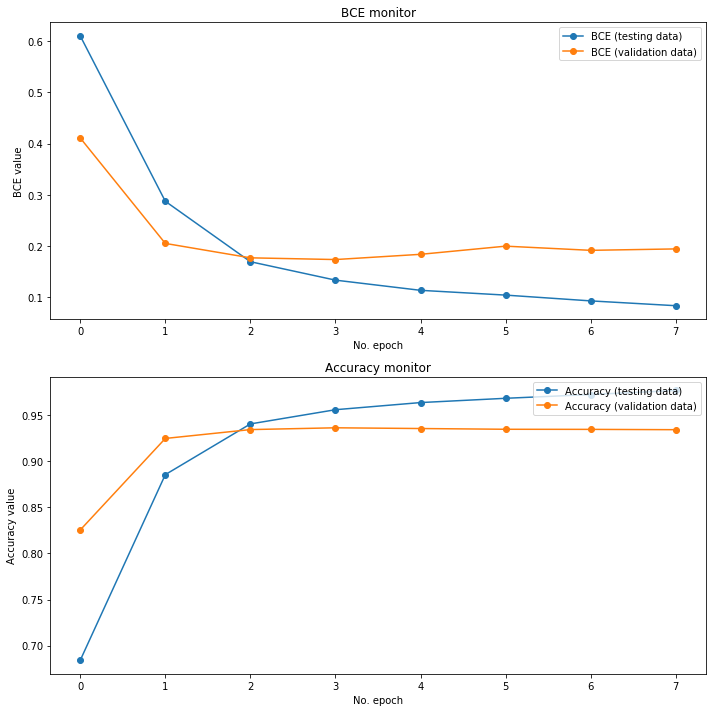

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
bidirecti

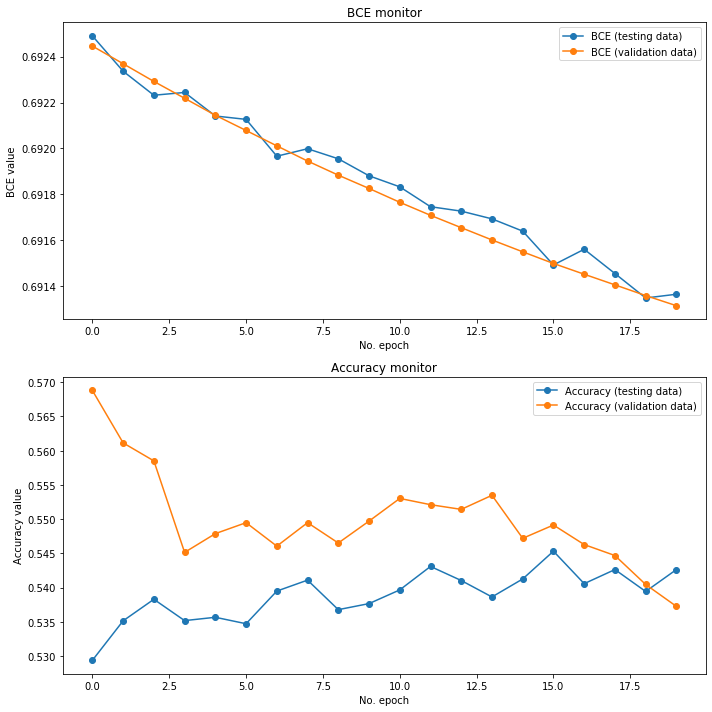

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
bidirectiona

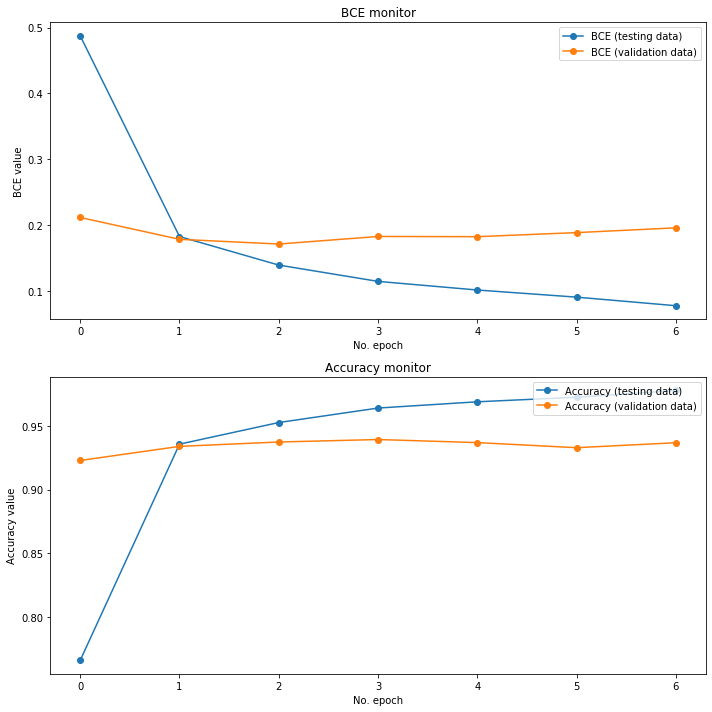

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
bidirecti

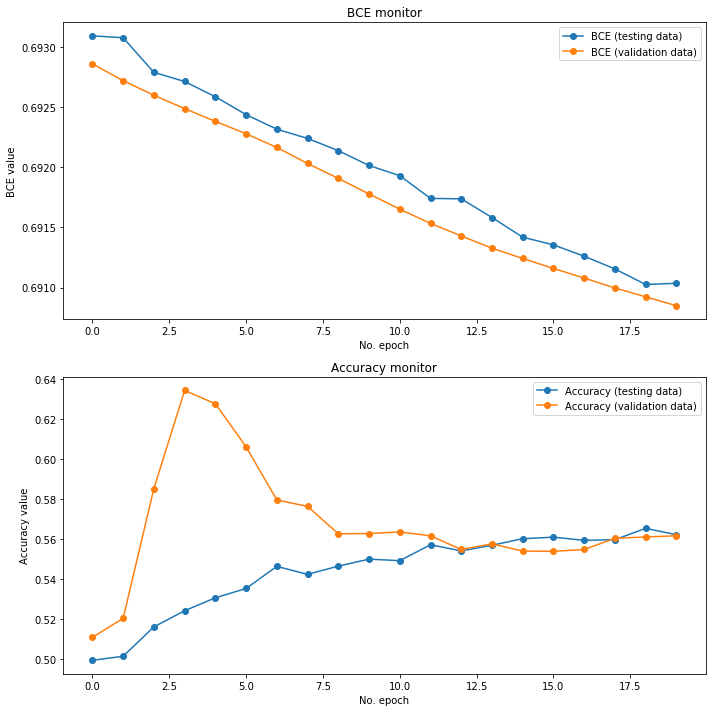

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
bidirectional

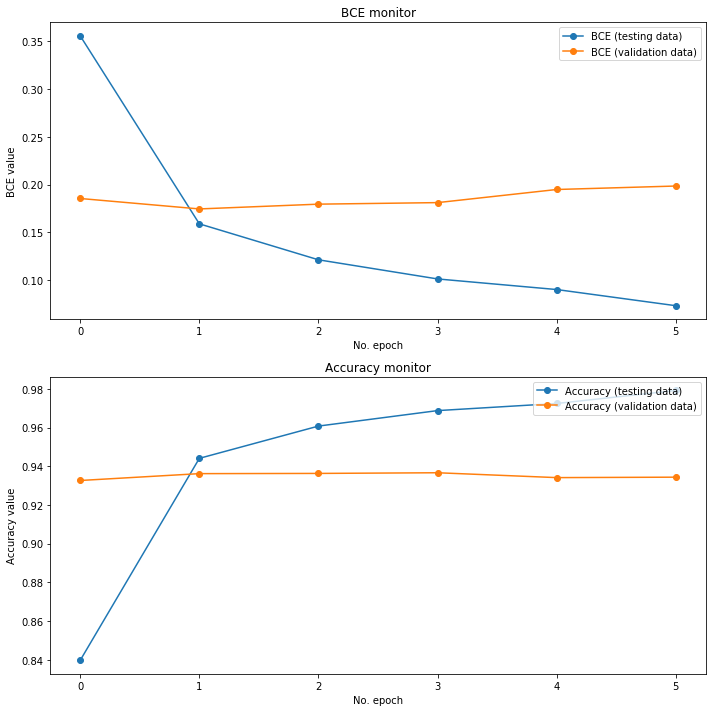

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 300, 200)          4910400   
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 300, 200)          240800    
_________________________________________________________________
bidirectio

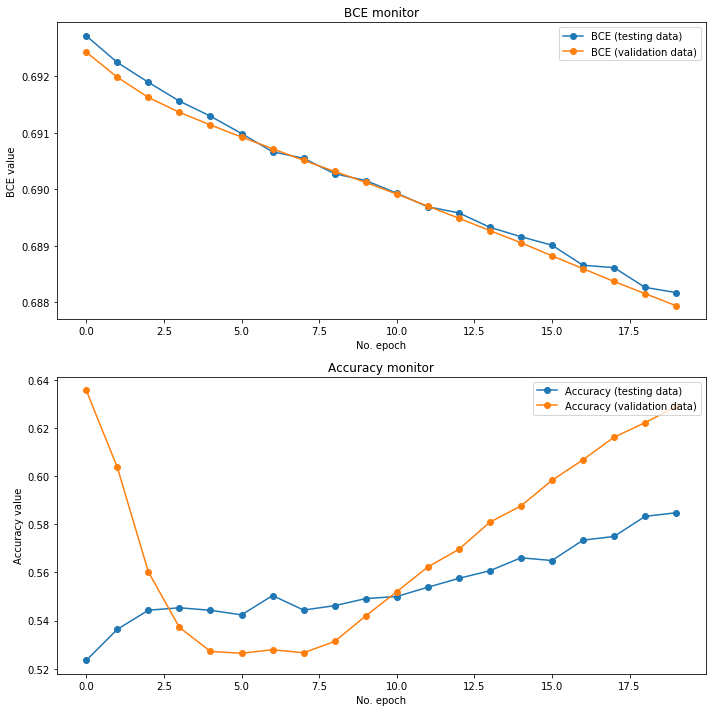

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
bidirectiona

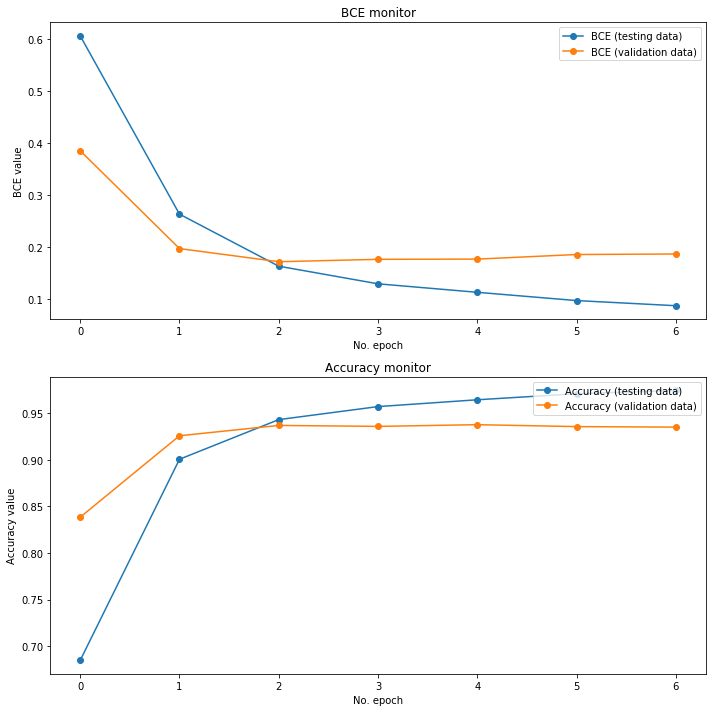

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
bidirecti

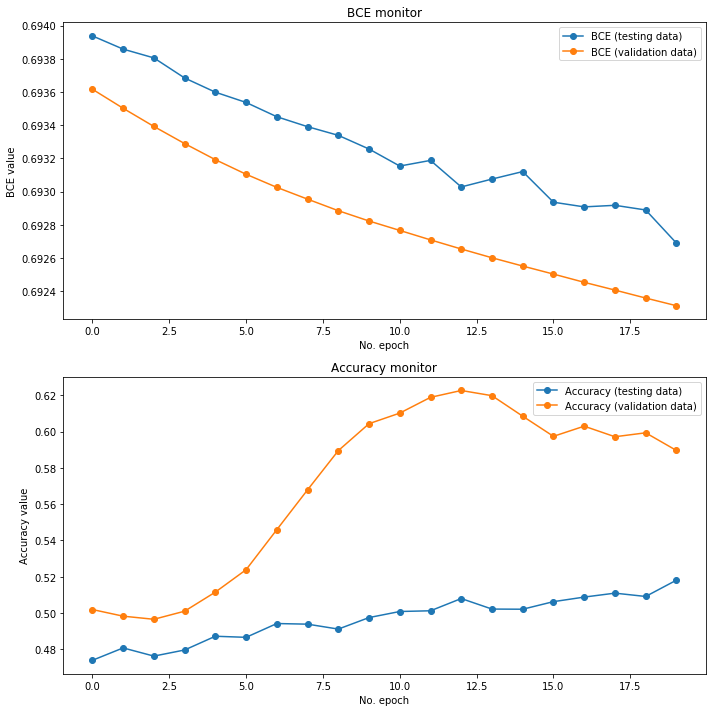

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_35 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
bidirectiona

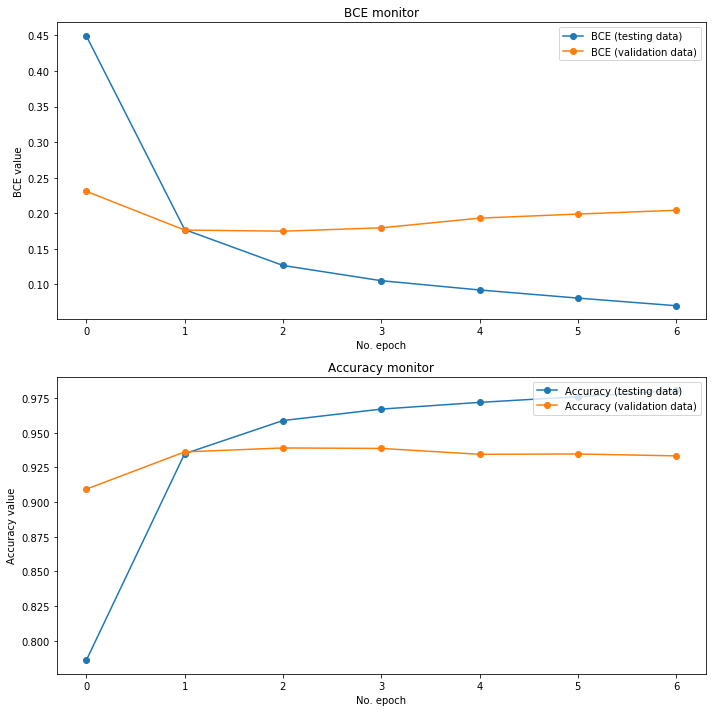

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
bidirecti

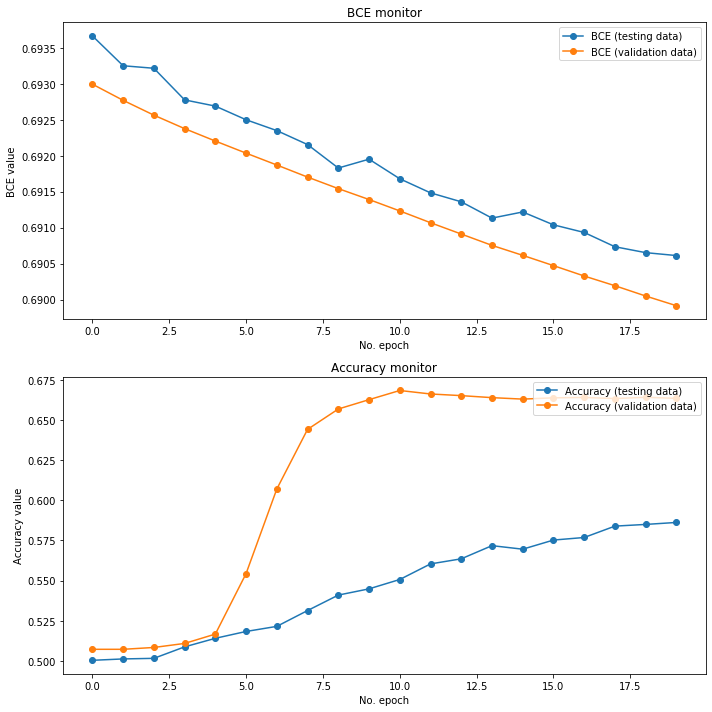

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
bidirectional

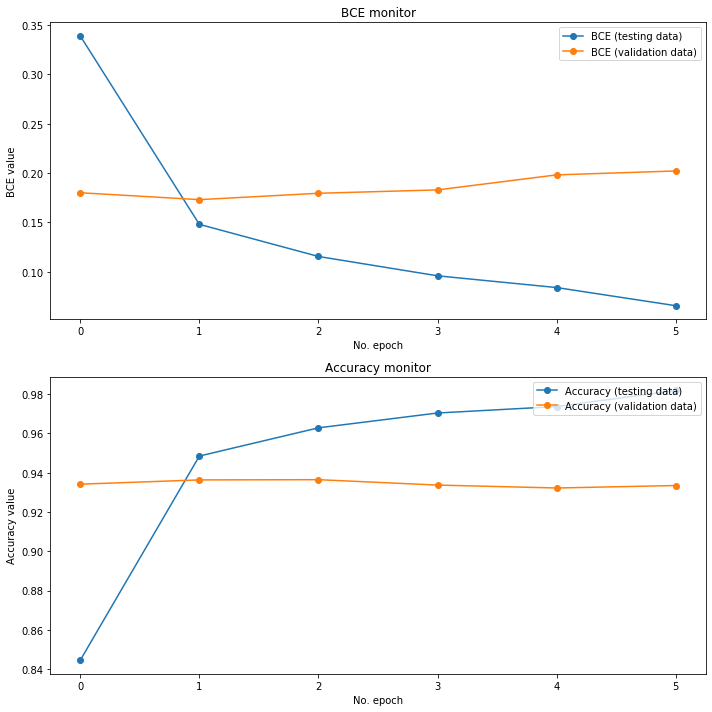

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_2layer', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_38 (Embedding)     (None, 300, 300)          7365600   
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 300, 200)          320800    
_________________________________________________________________
bidirectio

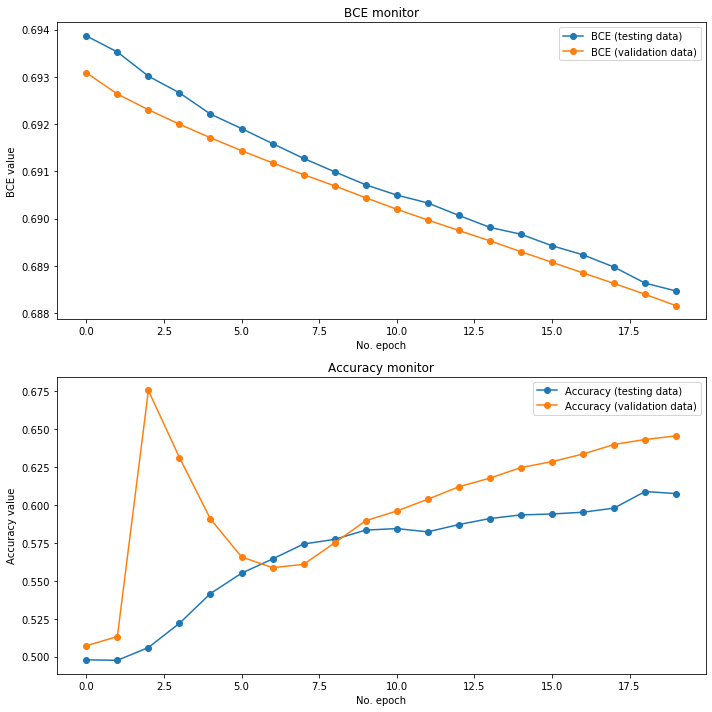

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 300, 100)     2455200     input_40[0][0]                   
_____________________________________________

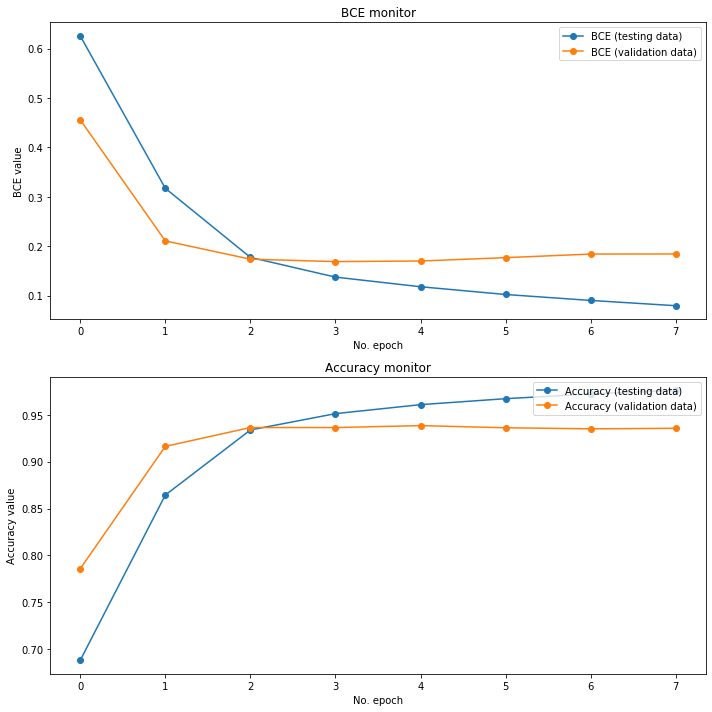

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 300, 100)     2455200     input_41[0][0]                   
__________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6907 - binary_accuracy: 0.5638
Epoch 00017: val_loss did not improve from 0.16876
34996/34996 [==============================] - 58s 2ms/sample - loss: 0.6907 - binary_accuracy: 0.5637 - val_loss: 0.6900 - val_binary_accuracy: 0.5910
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6906 - binary_accuracy: 0.5696
Epoch 00018: val_loss did not improve from 0.16876
34996/34996 [==============================] - 58s 2ms/sample - loss: 0.6906 - binary_accuracy: 0.5698 - val_loss: 0.6899 - val_binary_accuracy: 0.5927
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6905 - binary_accuracy: 0.5730
Epoch 00019: val_loss did not improve from 0.16876
34996/34996 [==============================] - 58s 2ms/sample - loss: 0.6905 - binary_accuracy: 0.5729 - val_loss: 0.6898 - val_binary_accuracy: 0.5951
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

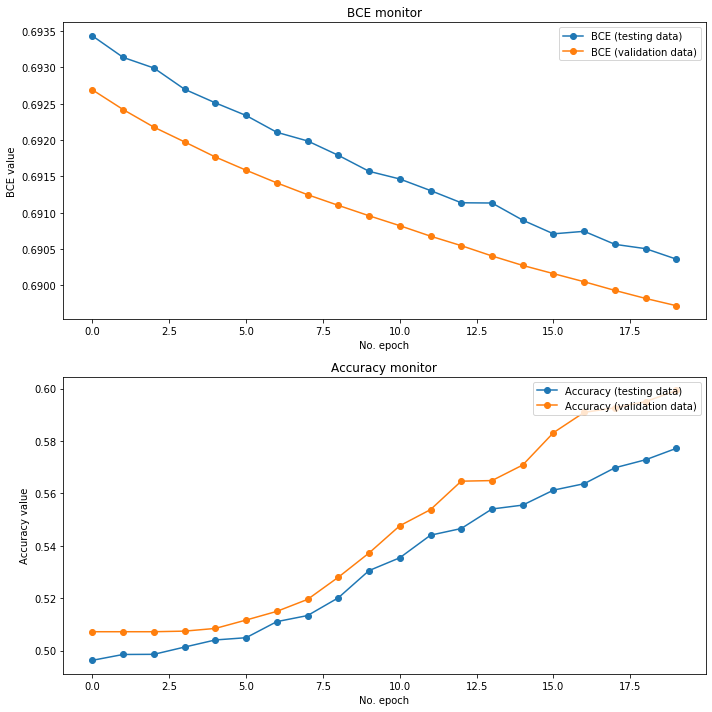

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 300, 100)     2455200     input_42[0][0]                   
_____________________________________________

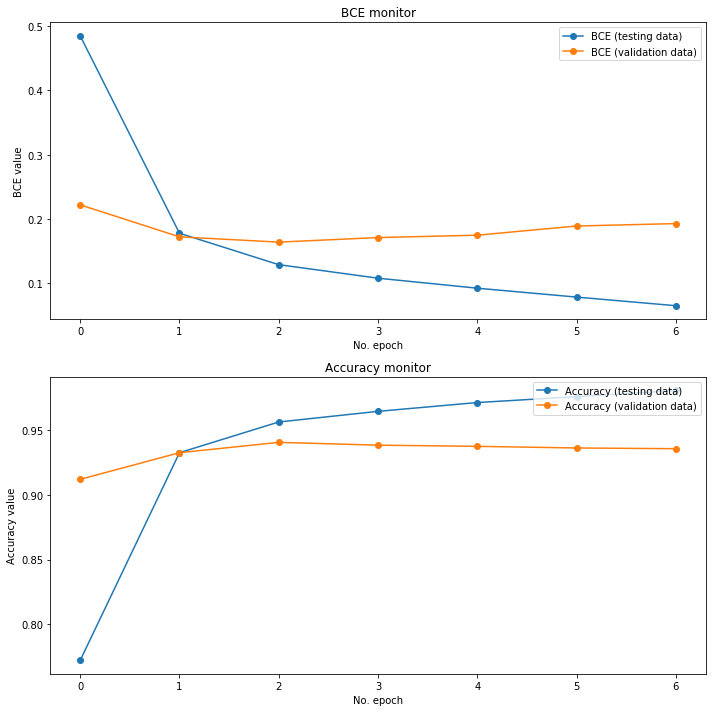

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_42 (Embedding)        (None, 300, 100)     2455200     input_43[0][0]                   
__________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6879 - binary_accuracy: 0.6335
Epoch 00017: val_loss did not improve from 0.16421
34996/34996 [==============================] - 66s 2ms/sample - loss: 0.6879 - binary_accuracy: 0.6332 - val_loss: 0.6879 - val_binary_accuracy: 0.6794
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6876 - binary_accuracy: 0.6327
Epoch 00018: val_loss did not improve from 0.16421
34996/34996 [==============================] - 66s 2ms/sample - loss: 0.6876 - binary_accuracy: 0.6327 - val_loss: 0.6877 - val_binary_accuracy: 0.6807
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6875 - binary_accuracy: 0.6364
Epoch 00019: val_loss did not improve from 0.16421
34996/34996 [==============================] - 66s 2ms/sample - loss: 0.6875 - binary_accuracy: 0.6364 - val_loss: 0.6875 - val_binary_accuracy: 0.6824
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

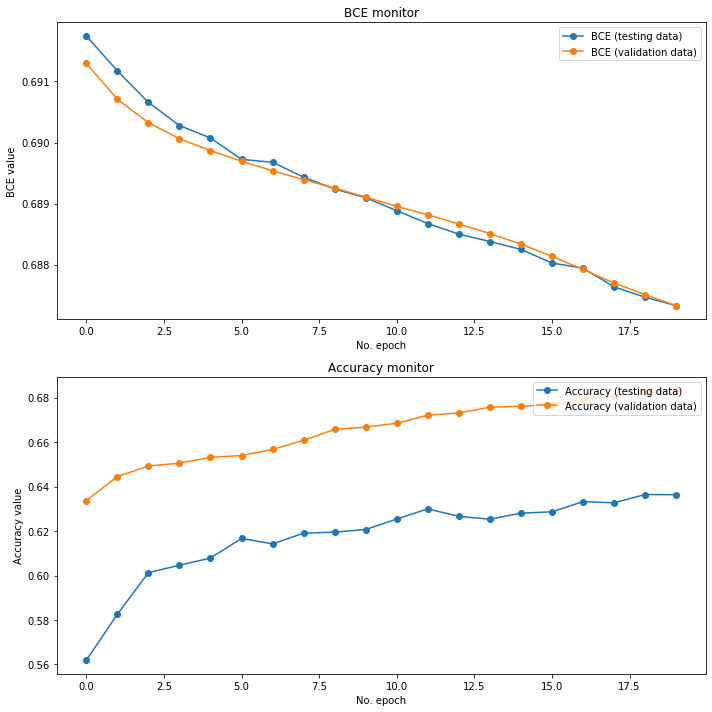

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_43 (Embedding)        (None, 300, 100)     2455200     input_44[0][0]                   
______________________________________________

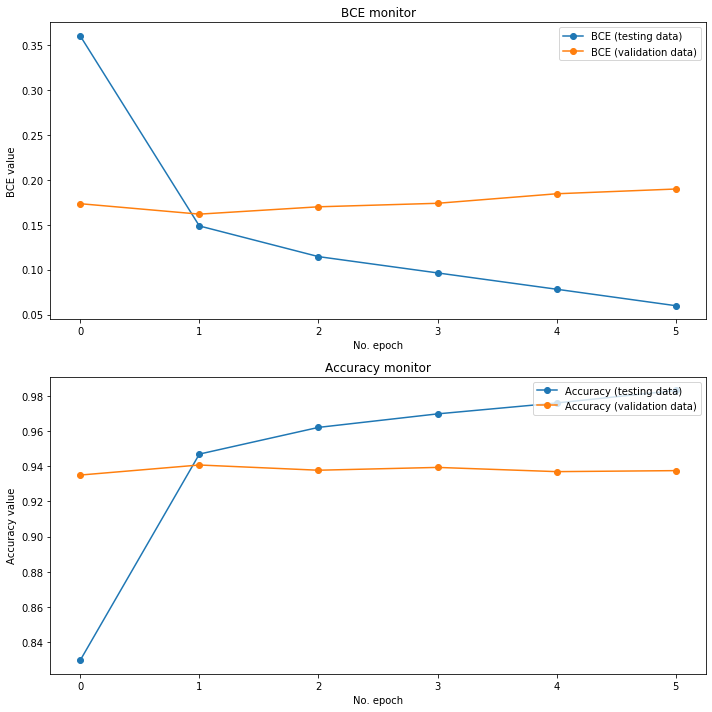

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 300, 100)     2455200     input_45[0][0]                   
___________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6808 - binary_accuracy: 0.6354
Epoch 00017: val_loss did not improve from 0.16180
34996/34996 [==============================] - 71s 2ms/sample - loss: 0.6808 - binary_accuracy: 0.6356 - val_loss: 0.6804 - val_binary_accuracy: 0.6896
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6803 - binary_accuracy: 0.6442
Epoch 00018: val_loss did not improve from 0.16180
34996/34996 [==============================] - 71s 2ms/sample - loss: 0.6803 - binary_accuracy: 0.6443 - val_loss: 0.6800 - val_binary_accuracy: 0.6896
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6800 - binary_accuracy: 0.6471
Epoch 00019: val_loss did not improve from 0.16180
34996/34996 [==============================] - 71s 2ms/sample - loss: 0.6800 - binary_accuracy: 0.6467 - val_loss: 0.6796 - val_binary_accuracy: 0.6879
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

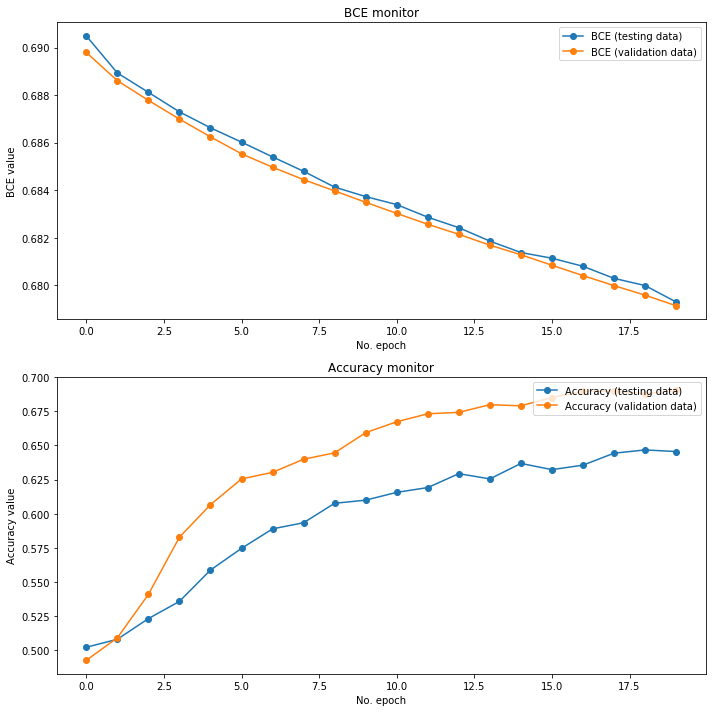

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 300, 200)     4910400     input_46[0][0]                   
_____________________________________________

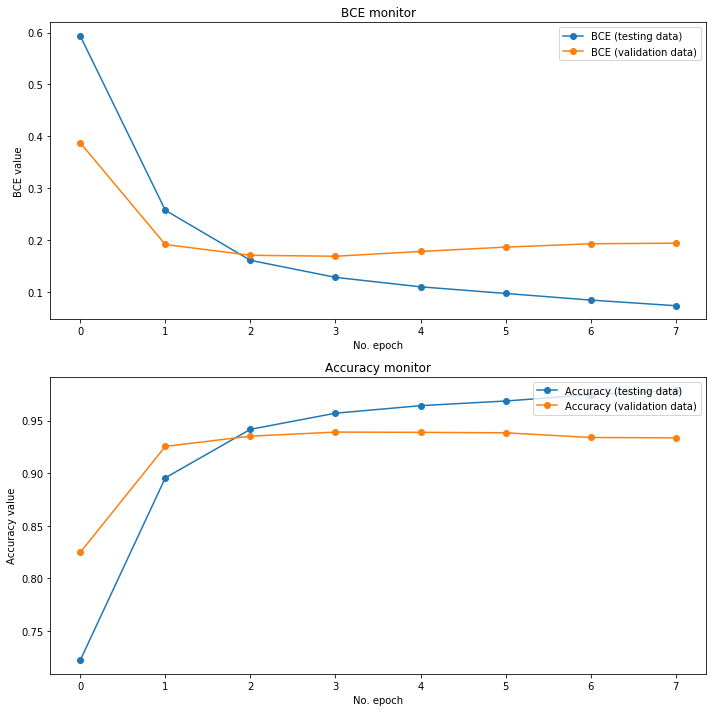

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, 300, 200)     4910400     input_47[0][0]                   
__________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6893 - binary_accuracy: 0.5703
Epoch 00017: val_loss did not improve from 0.16180
34996/34996 [==============================] - 75s 2ms/sample - loss: 0.6892 - binary_accuracy: 0.5704 - val_loss: 0.6889 - val_binary_accuracy: 0.6461
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6890 - binary_accuracy: 0.5802
Epoch 00018: val_loss did not improve from 0.16180
34996/34996 [==============================] - 74s 2ms/sample - loss: 0.6890 - binary_accuracy: 0.5800 - val_loss: 0.6888 - val_binary_accuracy: 0.6525
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6889 - binary_accuracy: 0.5828
Epoch 00019: val_loss did not improve from 0.16180
34996/34996 [==============================] - 73s 2ms/sample - loss: 0.6889 - binary_accuracy: 0.5828 - val_loss: 0.6887 - val_binary_accuracy: 0.6554
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

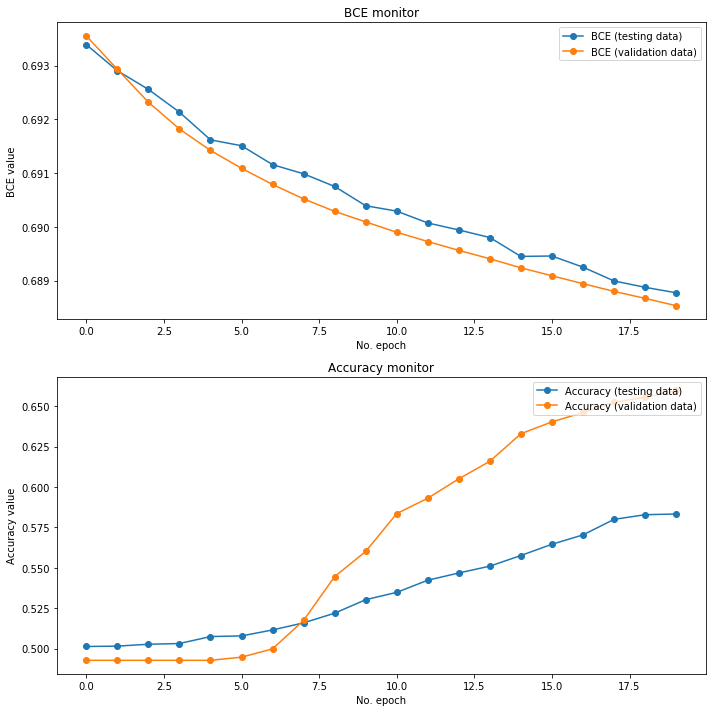

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 300, 200)     4910400     input_48[0][0]                   
_____________________________________________

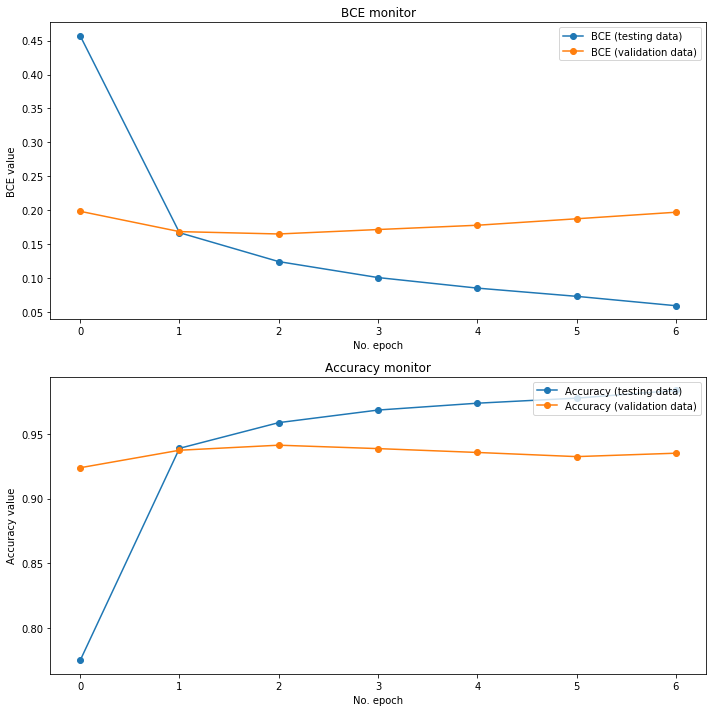

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 300, 200)     4910400     input_49[0][0]                   
__________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6876 - binary_accuracy: 0.6012
Epoch 00017: val_loss did not improve from 0.16180
34996/34996 [==============================] - 82s 2ms/sample - loss: 0.6876 - binary_accuracy: 0.6011 - val_loss: 0.6871 - val_binary_accuracy: 0.6686
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6872 - binary_accuracy: 0.6129
Epoch 00018: val_loss did not improve from 0.16180
34996/34996 [==============================] - 82s 2ms/sample - loss: 0.6872 - binary_accuracy: 0.6127 - val_loss: 0.6868 - val_binary_accuracy: 0.6688
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6870 - binary_accuracy: 0.6111
Epoch 00019: val_loss did not improve from 0.16180
34996/34996 [==============================] - 82s 2ms/sample - loss: 0.6870 - binary_accuracy: 0.6112 - val_loss: 0.6865 - val_binary_accuracy: 0.6728
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

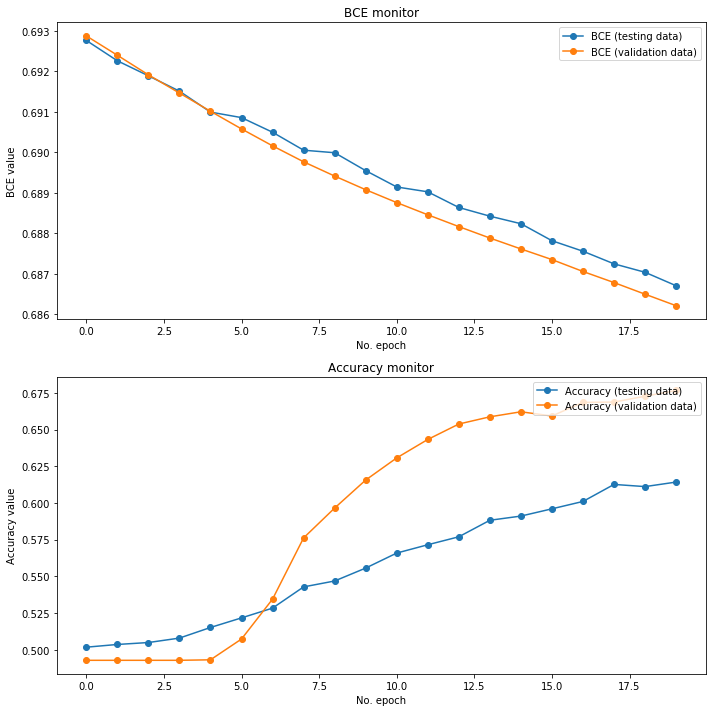

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 300, 200)     4910400     input_50[0][0]                   
______________________________________________

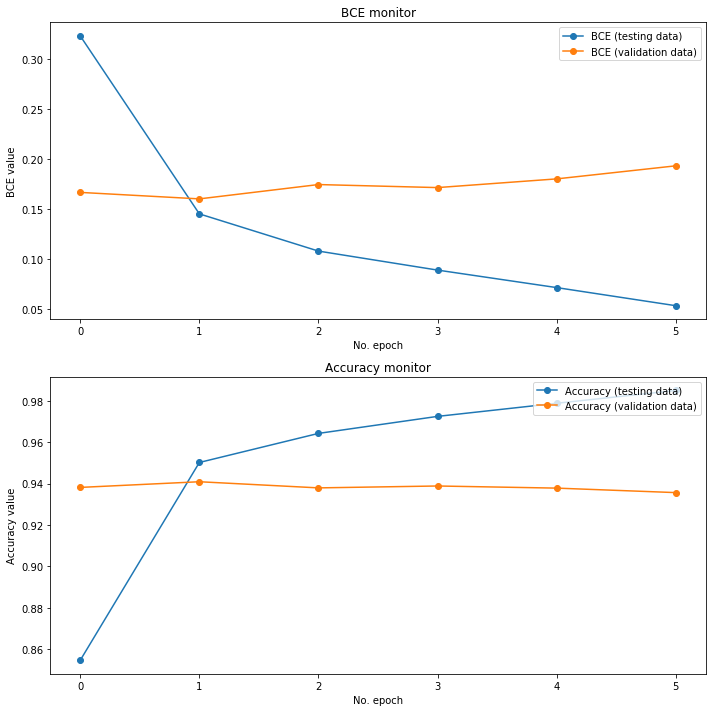

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_50 (Embedding)        (None, 300, 200)     4910400     input_51[0][0]                   
___________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6803 - binary_accuracy: 0.6570
Epoch 00017: val_loss did not improve from 0.16009
34996/34996 [==============================] - 92s 3ms/sample - loss: 0.6803 - binary_accuracy: 0.6571 - val_loss: 0.6799 - val_binary_accuracy: 0.6687
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6798 - binary_accuracy: 0.6606
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 92s 3ms/sample - loss: 0.6798 - binary_accuracy: 0.6606 - val_loss: 0.6794 - val_binary_accuracy: 0.6696
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6793 - binary_accuracy: 0.6579
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 92s 3ms/sample - loss: 0.6793 - binary_accuracy: 0.6579 - val_loss: 0.6789 - val_binary_accuracy: 0.6713
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

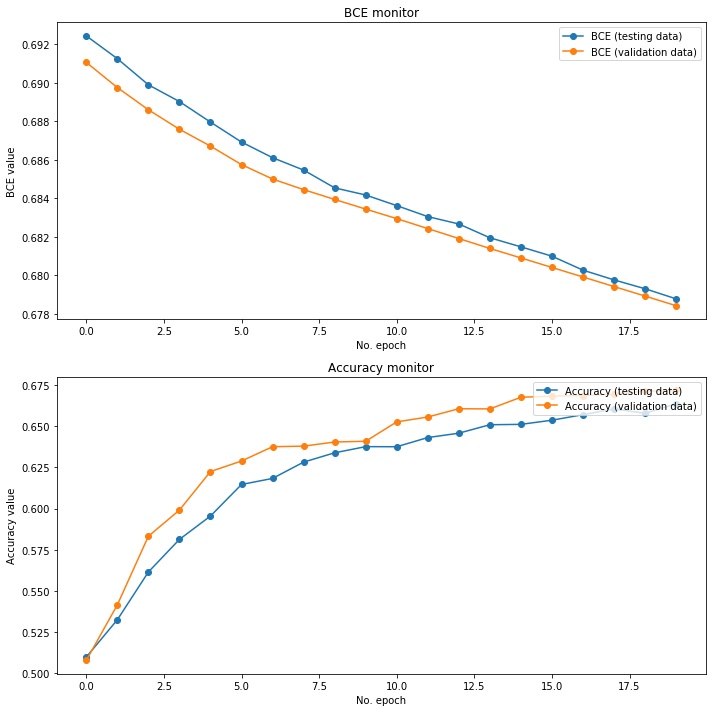

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 300, 300)     7365600     input_52[0][0]                   
_____________________________________________

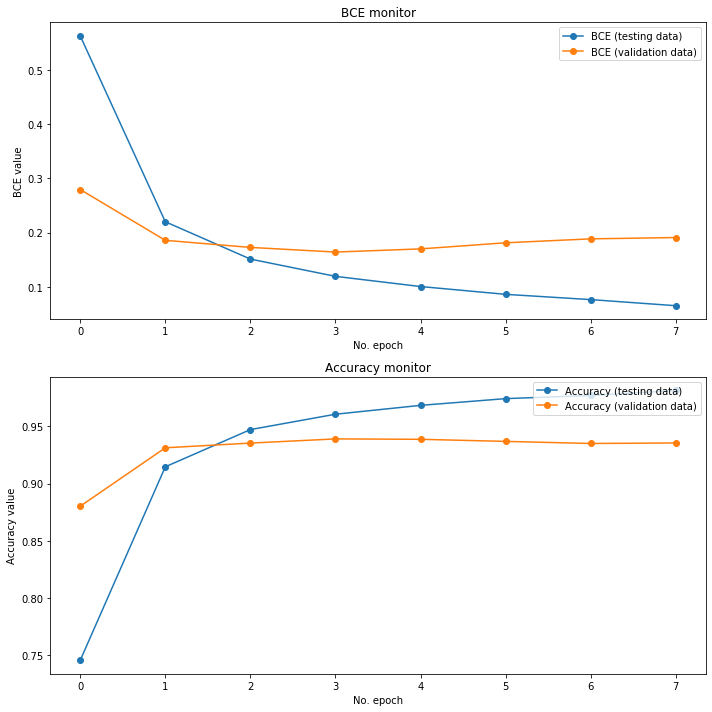

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 300, 300)     7365600     input_53[0][0]                   
__________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6894 - binary_accuracy: 0.5949
Epoch 00017: val_loss did not improve from 0.16009
34996/34996 [==============================] - 89s 3ms/sample - loss: 0.6894 - binary_accuracy: 0.5947 - val_loss: 0.6887 - val_binary_accuracy: 0.6685
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6891 - binary_accuracy: 0.5979
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 90s 3ms/sample - loss: 0.6891 - binary_accuracy: 0.5978 - val_loss: 0.6885 - val_binary_accuracy: 0.6696
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6890 - binary_accuracy: 0.5996
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 90s 3ms/sample - loss: 0.6890 - binary_accuracy: 0.5996 - val_loss: 0.6882 - val_binary_accuracy: 0.6710
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

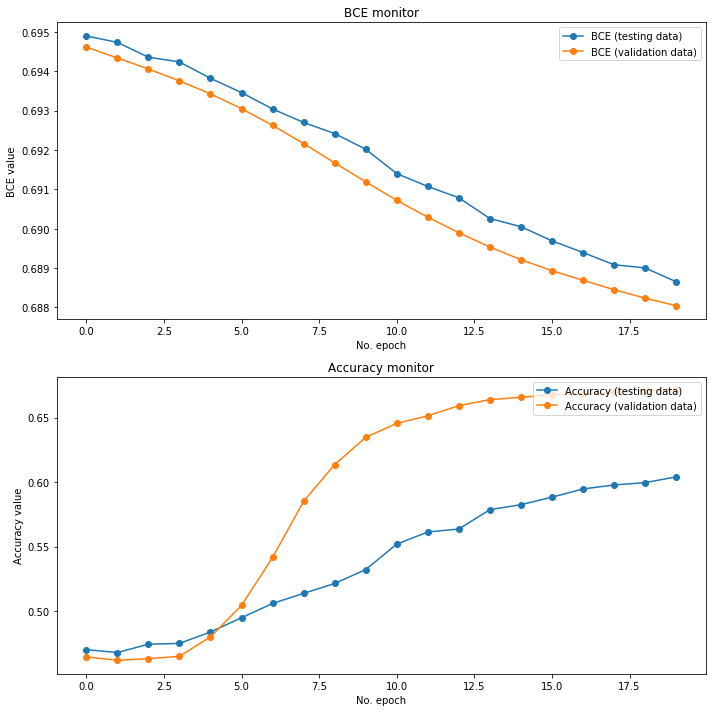

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 300, 300)     7365600     input_54[0][0]                   
_____________________________________________

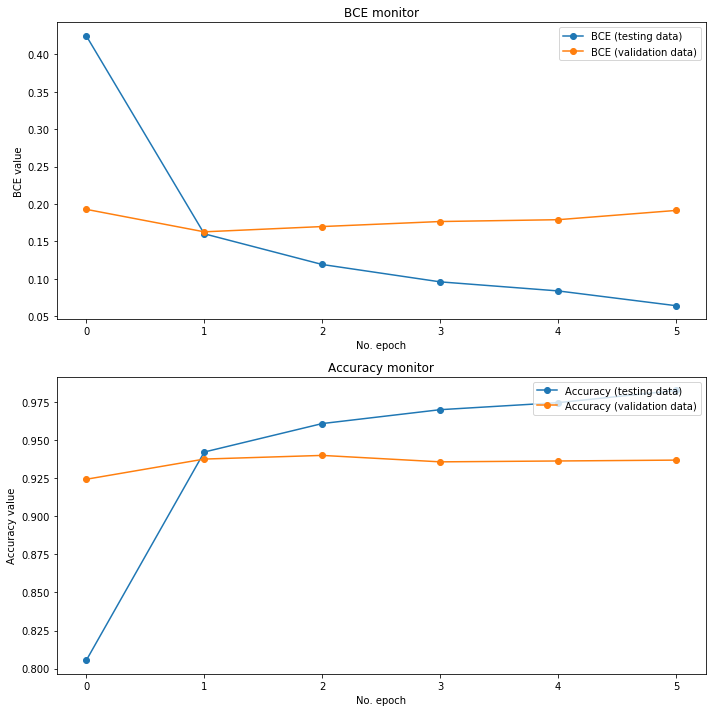

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 300, 300)     7365600     input_55[0][0]                   
__________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6794 - binary_accuracy: 0.6528
Epoch 00017: val_loss did not improve from 0.16009
34996/34996 [==============================] - 98s 3ms/sample - loss: 0.6794 - binary_accuracy: 0.6529 - val_loss: 0.6788 - val_binary_accuracy: 0.6885
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6790 - binary_accuracy: 0.6585
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 98s 3ms/sample - loss: 0.6789 - binary_accuracy: 0.6589 - val_loss: 0.6783 - val_binary_accuracy: 0.6874
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6786 - binary_accuracy: 0.6567
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 98s 3ms/sample - loss: 0.6785 - binary_accuracy: 0.6570 - val_loss: 0.6779 - val_binary_accuracy: 0.6882
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s 

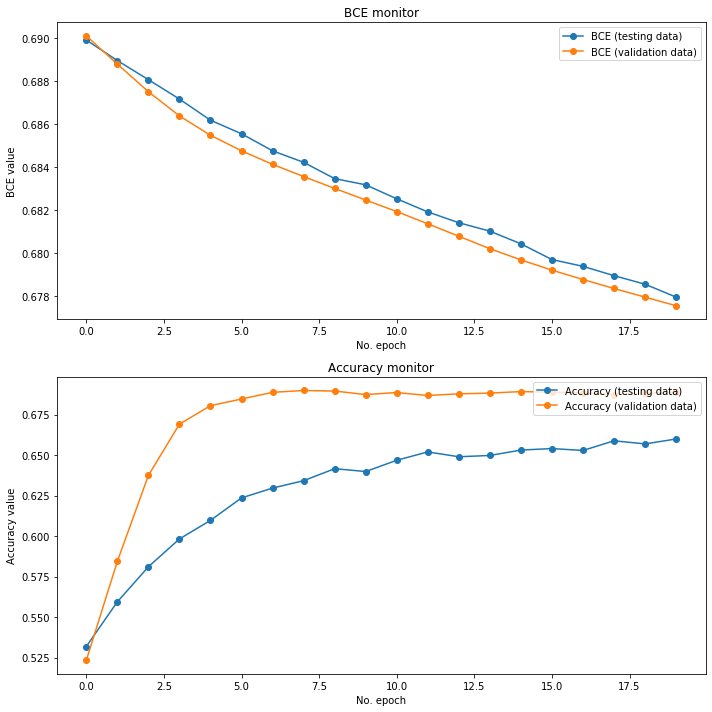

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 300, 300)     7365600     input_56[0][0]                   
______________________________________________

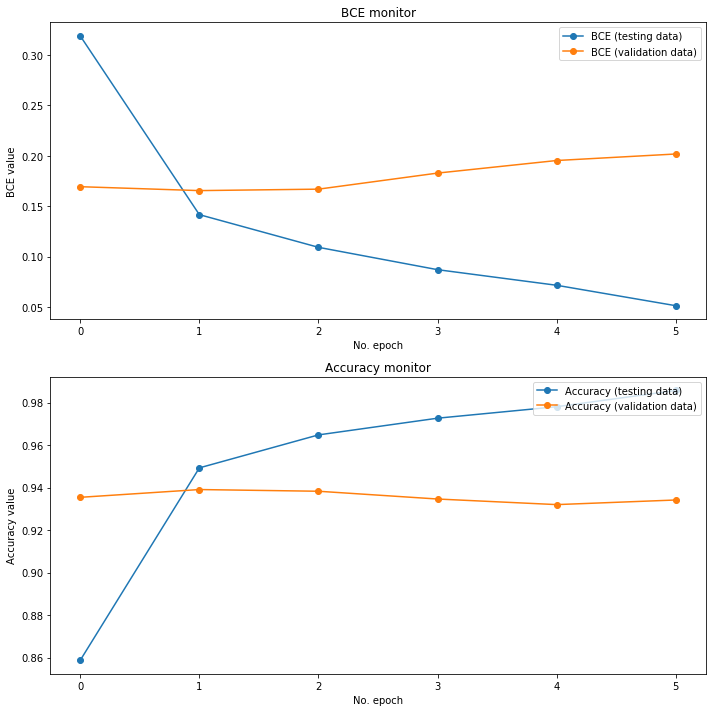

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_conv1d', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
##################################################
====> training using single gpu or cpu
##################################################
model_name_argument : None, write the model_name
Model: "model_56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 300, 300)     7365600     input_57[0][0]                   
___________________________________________

Epoch 17/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6765 - binary_accuracy: 0.6730
Epoch 00017: val_loss did not improve from 0.16009
34996/34996 [==============================] - 104s 3ms/sample - loss: 0.6765 - binary_accuracy: 0.6732 - val_loss: 0.6760 - val_binary_accuracy: 0.6904
Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6759 - binary_accuracy: 0.6739
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 104s 3ms/sample - loss: 0.6759 - binary_accuracy: 0.6740 - val_loss: 0.6754 - val_binary_accuracy: 0.6910
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6753 - binary_accuracy: 0.6756
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 104s 3ms/sample - loss: 0.6753 - binary_accuracy: 0.6758 - val_loss: 0.6748 - val_binary_accuracy: 0.6912
Epoch 20/20
34816/34996 [============================>.] - ETA: 

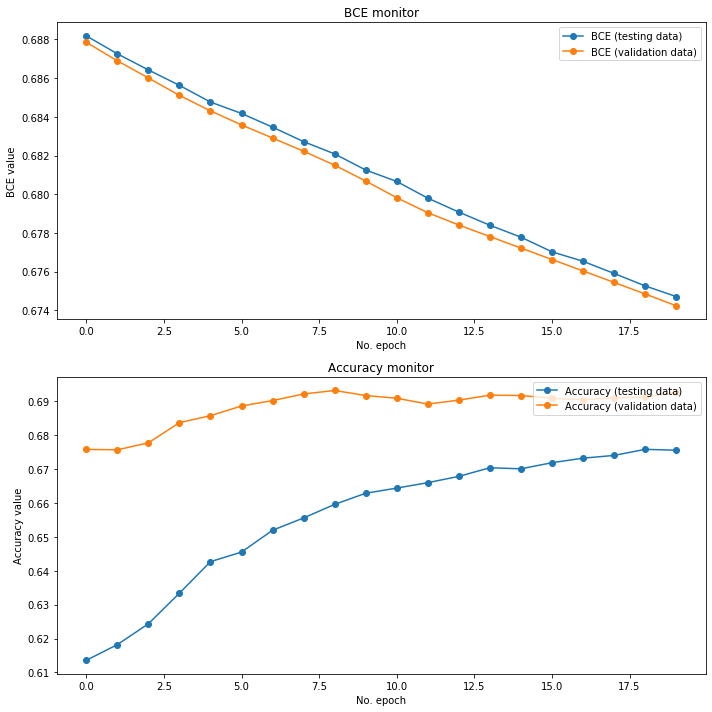

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 300, 100)     2455200     input_58[0][0]                   
__________________________________________________________________________________________________
dropout_57 (Dropout)            (None, 300, 100)     0           embedding_57[0][0]               
__________________________________

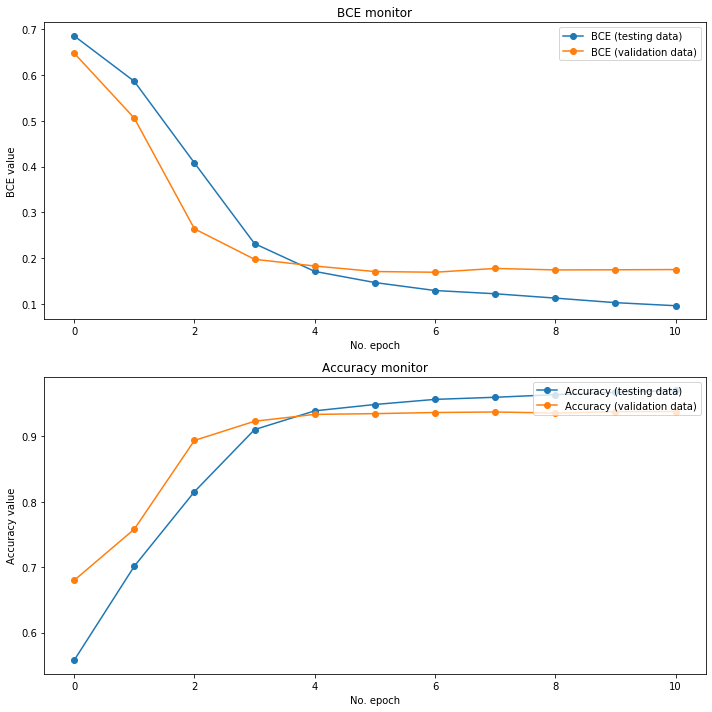

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
Model: "model_58"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_58 (Embedding)        (None, 300, 100)     2455200     input_59[0][0]                   
__________________________________________________________________________________________________
dropout_59 (Dropout)            (None, 300, 100)     0           embedding_58[0][0]               
_______________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6929 - binary_accuracy: 0.5106
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 59s 2ms/sample - loss: 0.6929 - binary_accuracy: 0.5109 - val_loss: 0.6928 - val_binary_accuracy: 0.5131
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5064
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 59s 2ms/sample - loss: 0.6930 - binary_accuracy: 0.5063 - val_loss: 0.6928 - val_binary_accuracy: 0.5130
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5042
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 59s 2ms/sample - loss: 0.6930 - binary_accuracy: 0.5041 - val_loss: 0.6928 - val_binary_accuracy: 0.5130


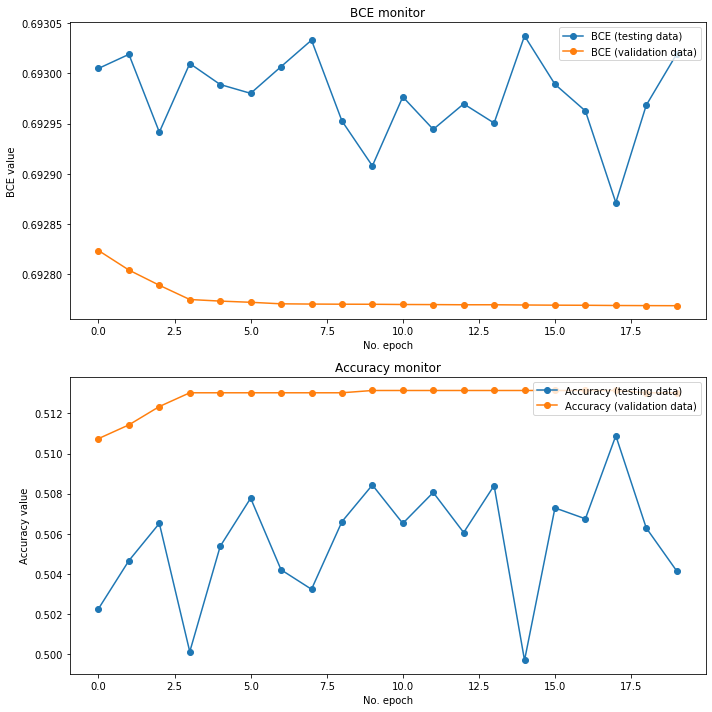

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_59 (Embedding)        (None, 300, 100)     2455200     input_60[0][0]                   
__________________________________________________________________________________________________
dropout_61 (Dropout)            (None, 300, 100)     0           embedding_59[0][0]               
__________________________________

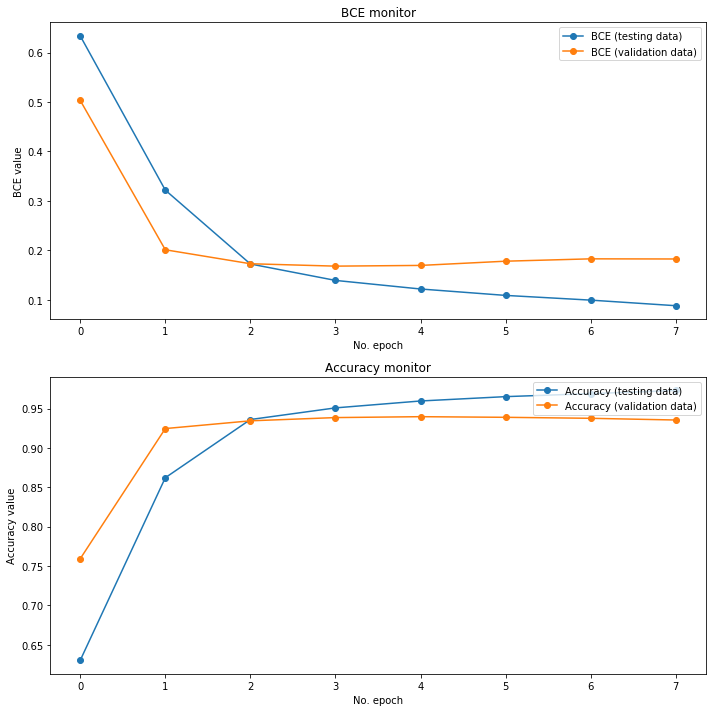

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_60 (Embedding)        (None, 300, 100)     2455200     input_61[0][0]                   
__________________________________________________________________________________________________
dropout_63 (Dropout)            (None, 300, 100)     0           embedding_60[0][0]               
_______________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5040
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 66s 2ms/sample - loss: 0.6930 - binary_accuracy: 0.5039 - val_loss: 0.6929 - val_binary_accuracy: 0.5135
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5038
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 65s 2ms/sample - loss: 0.6930 - binary_accuracy: 0.5037 - val_loss: 0.6929 - val_binary_accuracy: 0.5135
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5053
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 66s 2ms/sample - loss: 0.6930 - binary_accuracy: 0.5051 - val_loss: 0.6929 - val_binary_accuracy: 0.5135


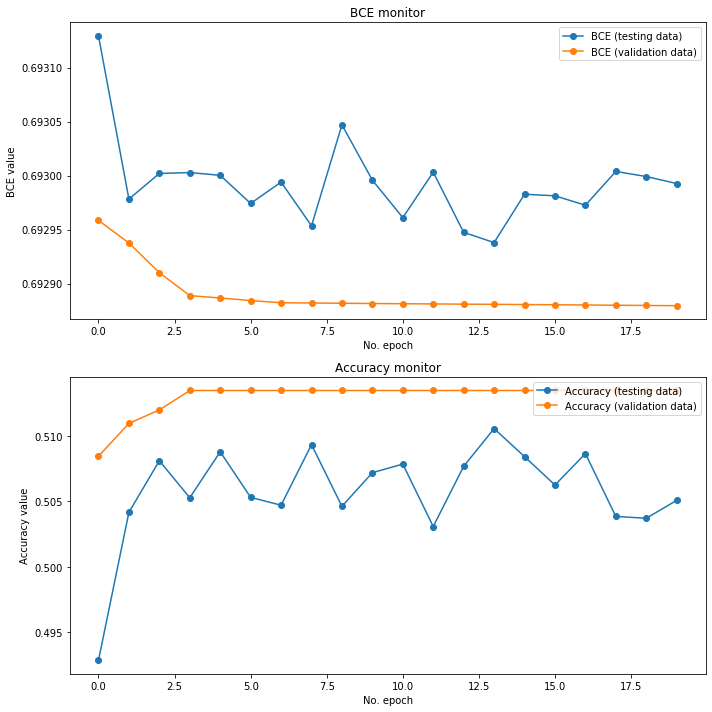

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 300, 100)     2455200     input_62[0][0]                   
__________________________________________________________________________________________________
dropout_65 (Dropout)            (None, 300, 100)     0           embedding_61[0][0]               
___________________________________

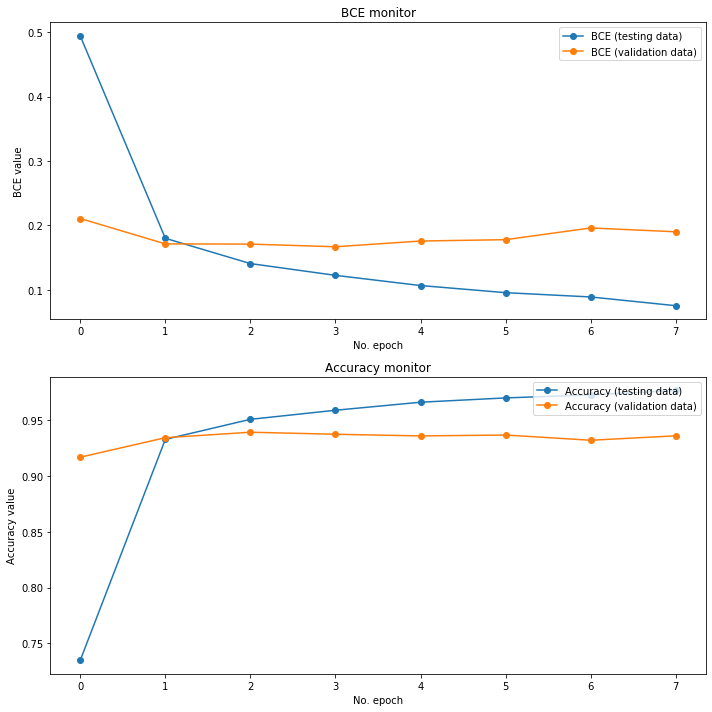

Namespace(activation='relu', dropout=0.3, embedding_dim=100, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 300, 100)     2455200     input_63[0][0]                   
__________________________________________________________________________________________________
dropout_67 (Dropout)            (None, 300, 100)     0           embedding_62[0][0]               
________________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6926 - binary_accuracy: 0.5220
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 67s 2ms/sample - loss: 0.6926 - binary_accuracy: 0.5219 - val_loss: 0.6925 - val_binary_accuracy: 0.5309
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6926 - binary_accuracy: 0.5255
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 67s 2ms/sample - loss: 0.6926 - binary_accuracy: 0.5255 - val_loss: 0.6924 - val_binary_accuracy: 0.5344
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6925 - binary_accuracy: 0.5237
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 67s 2ms/sample - loss: 0.6925 - binary_accuracy: 0.5236 - val_loss: 0.6924 - val_binary_accuracy: 0.5410


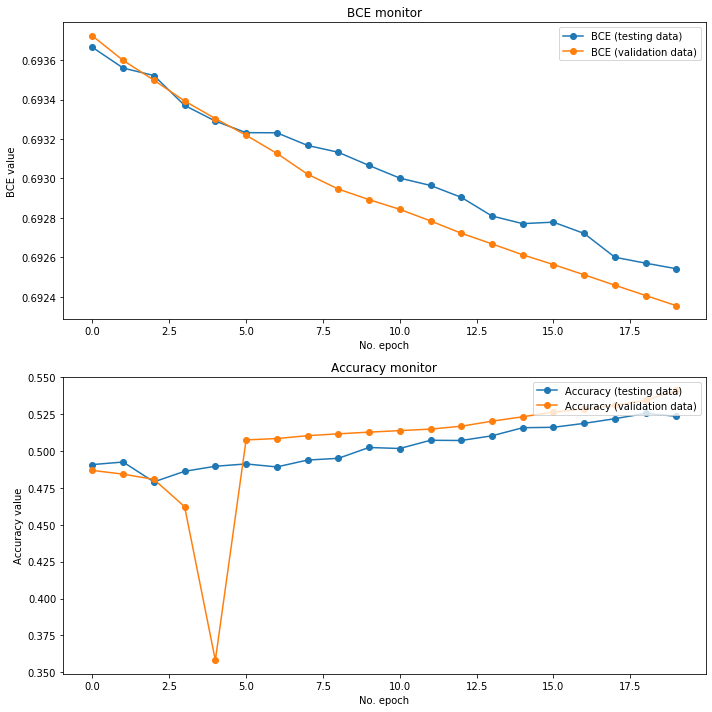

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_63 (Embedding)        (None, 300, 200)     4910400     input_64[0][0]                   
__________________________________________________________________________________________________
dropout_69 (Dropout)            (None, 300, 200)     0           embedding_63[0][0]               
__________________________________

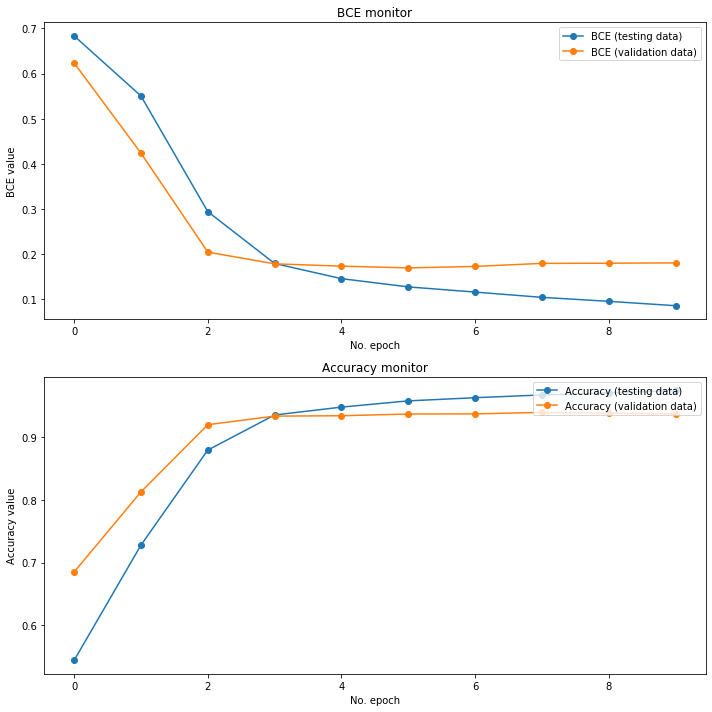

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_64 (Embedding)        (None, 300, 200)     4910400     input_65[0][0]                   
__________________________________________________________________________________________________
dropout_71 (Dropout)            (None, 300, 200)     0           embedding_64[0][0]               
_______________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6935 - binary_accuracy: 0.4953
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 78s 2ms/sample - loss: 0.6935 - binary_accuracy: 0.4952 - val_loss: 0.6932 - val_binary_accuracy: 0.5195
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6934 - binary_accuracy: 0.4964
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 77s 2ms/sample - loss: 0.6934 - binary_accuracy: 0.4964 - val_loss: 0.6932 - val_binary_accuracy: 0.5209
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6934 - binary_accuracy: 0.5018
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 77s 2ms/sample - loss: 0.6934 - binary_accuracy: 0.5021 - val_loss: 0.6932 - val_binary_accuracy: 0.5213


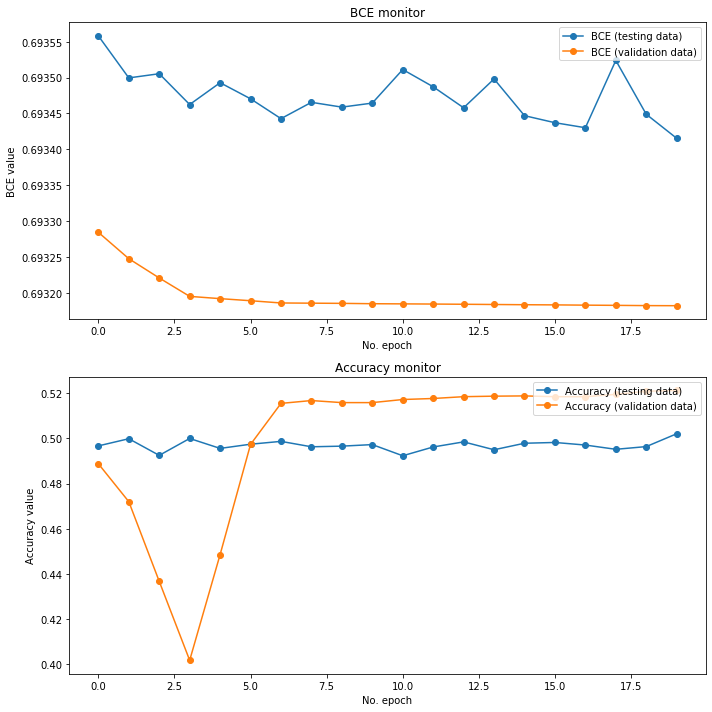

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 300, 200)     4910400     input_66[0][0]                   
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 300, 200)     0           embedding_65[0][0]               
__________________________________

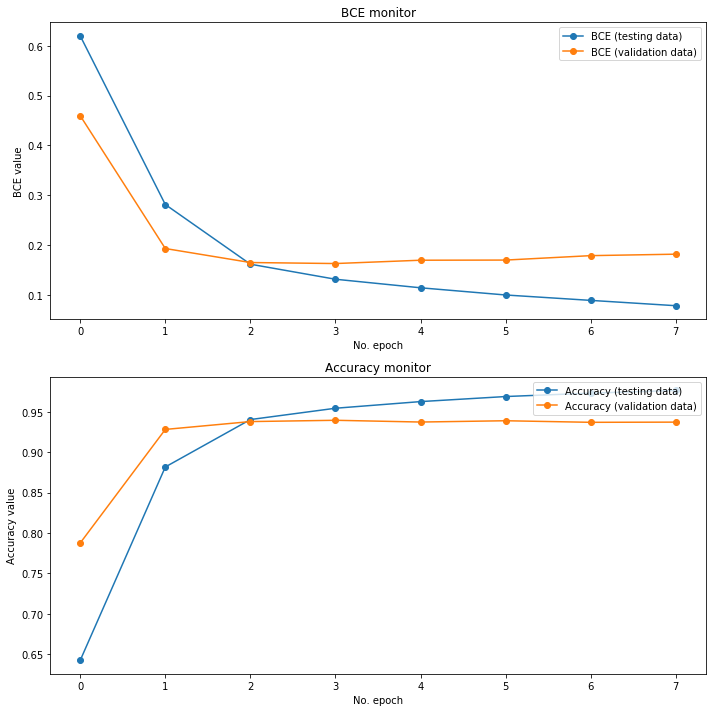

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_66 (Embedding)        (None, 300, 200)     4910400     input_67[0][0]                   
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 300, 200)     0           embedding_66[0][0]               
_______________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.4957
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 83s 2ms/sample - loss: 0.6931 - binary_accuracy: 0.4953 - val_loss: 0.6927 - val_binary_accuracy: 0.5131
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.4966
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 83s 2ms/sample - loss: 0.6931 - binary_accuracy: 0.4963 - val_loss: 0.6927 - val_binary_accuracy: 0.5136
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5051
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 83s 2ms/sample - loss: 0.6930 - binary_accuracy: 0.5049 - val_loss: 0.6926 - val_binary_accuracy: 0.5144


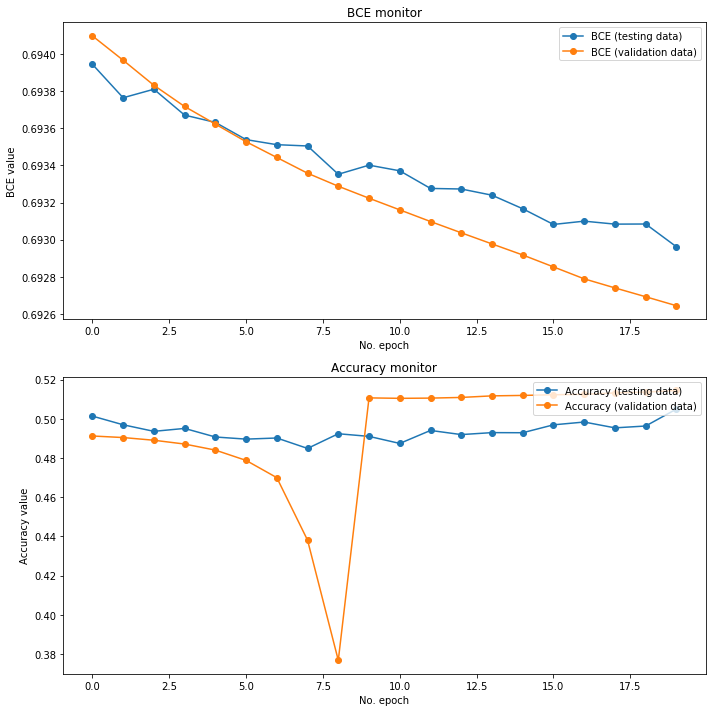

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 300, 200)     4910400     input_68[0][0]                   
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 300, 200)     0           embedding_67[0][0]               
___________________________________

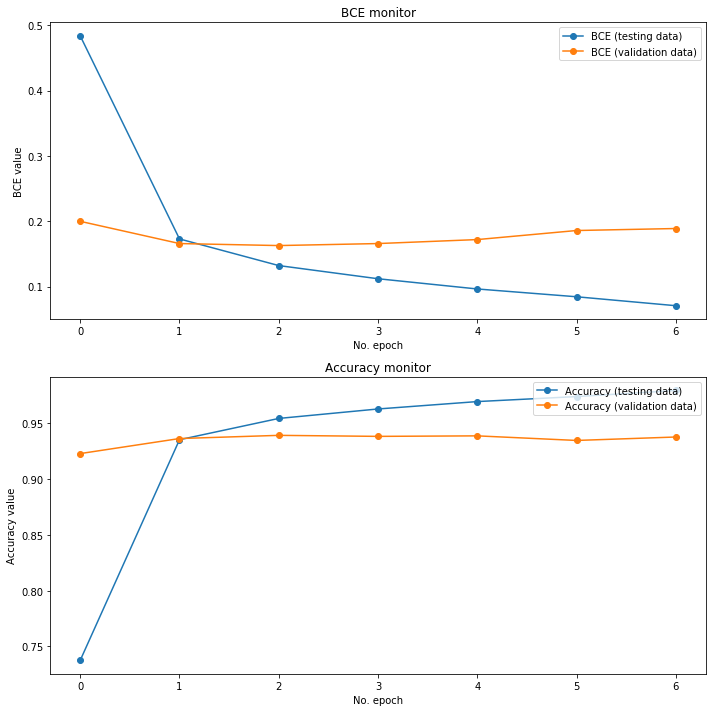

Namespace(activation='relu', dropout=0.3, embedding_dim=200, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
Model: "model_68"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_68 (Embedding)        (None, 300, 200)     4910400     input_69[0][0]                   
__________________________________________________________________________________________________
dropout_79 (Dropout)            (None, 300, 200)     0           embedding_68[0][0]               
________________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6926 - binary_accuracy: 0.5204
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 90s 3ms/sample - loss: 0.6927 - binary_accuracy: 0.5203 - val_loss: 0.6921 - val_binary_accuracy: 0.5209
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6926 - binary_accuracy: 0.5212
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 90s 3ms/sample - loss: 0.6926 - binary_accuracy: 0.5215 - val_loss: 0.6921 - val_binary_accuracy: 0.5224
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6925 - binary_accuracy: 0.5210
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 90s 3ms/sample - loss: 0.6925 - binary_accuracy: 0.5211 - val_loss: 0.6920 - val_binary_accuracy: 0.5238


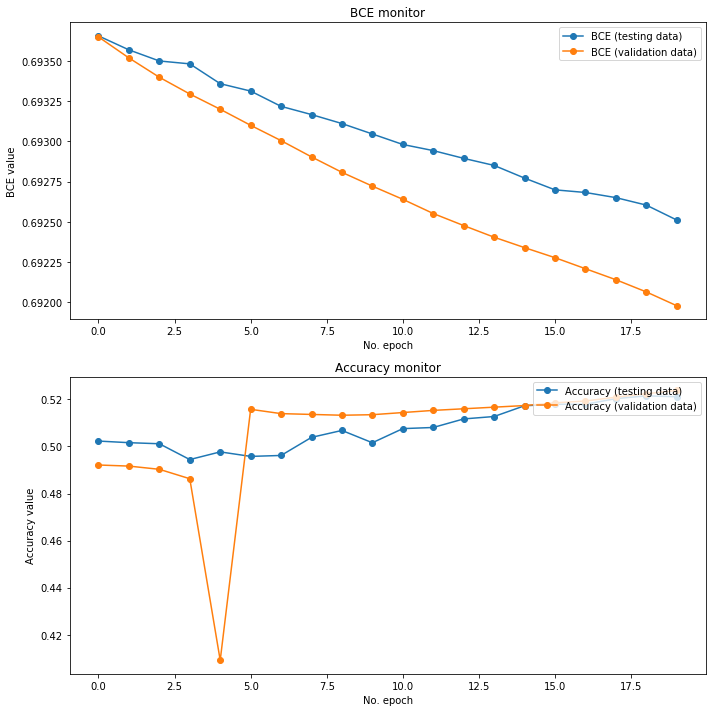

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 300, 300)     7365600     input_70[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 300, 300)     0           embedding_69[0][0]               
__________________________________

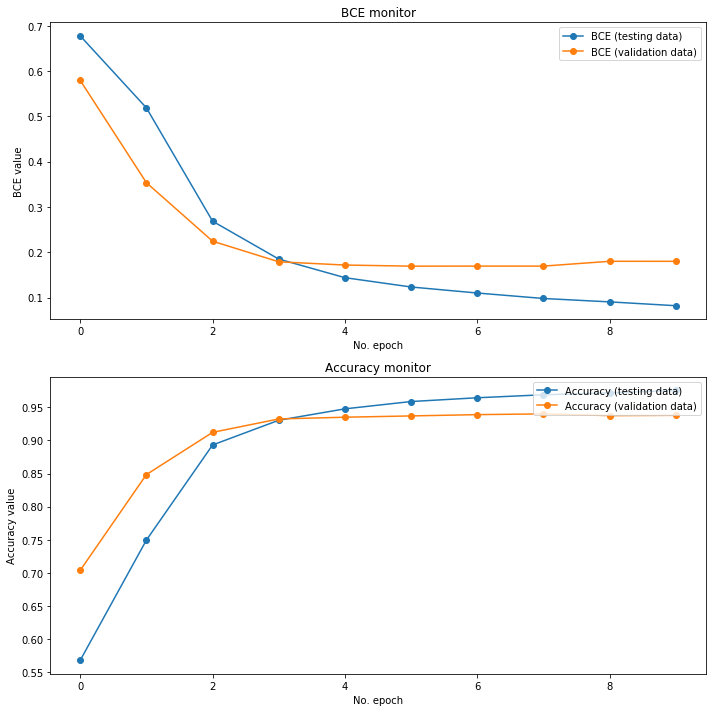

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=2048, validation_split=0.2, verbose=1)
Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 300, 300)     7365600     input_71[0][0]                   
__________________________________________________________________________________________________
dropout_83 (Dropout)            (None, 300, 300)     0           embedding_70[0][0]               
_______________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6933 - binary_accuracy: 0.4891
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 97s 3ms/sample - loss: 0.6933 - binary_accuracy: 0.4888 - val_loss: 0.6931 - val_binary_accuracy: 0.5079
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.4955
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 97s 3ms/sample - loss: 0.6932 - binary_accuracy: 0.4959 - val_loss: 0.6931 - val_binary_accuracy: 0.5077
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.4940
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 97s 3ms/sample - loss: 0.6931 - binary_accuracy: 0.4943 - val_loss: 0.6931 - val_binary_accuracy: 0.5077


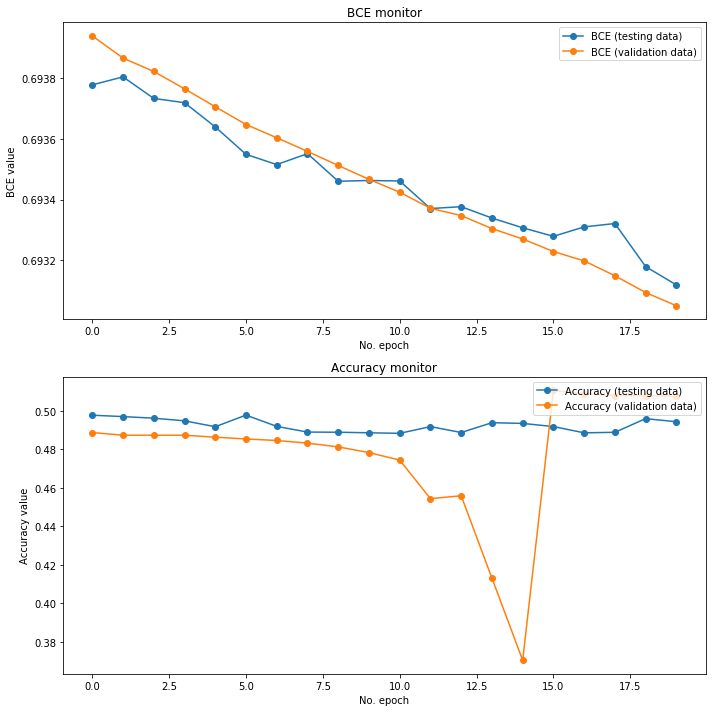

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 300, 300)     7365600     input_72[0][0]                   
__________________________________________________________________________________________________
dropout_85 (Dropout)            (None, 300, 300)     0           embedding_71[0][0]               
__________________________________

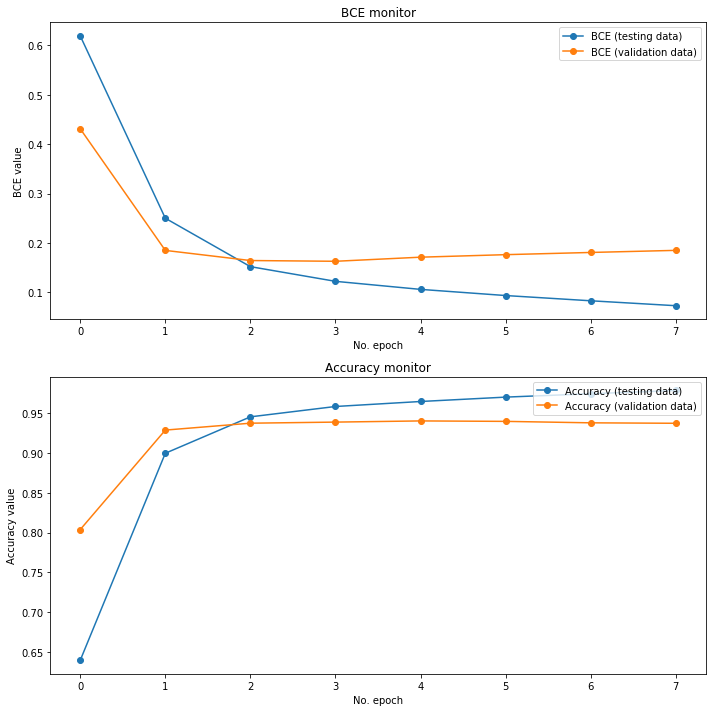

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=1024, validation_split=0.2, verbose=1)
Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_72 (Embedding)        (None, 300, 300)     7365600     input_73[0][0]                   
__________________________________________________________________________________________________
dropout_87 (Dropout)            (None, 300, 300)     0           embedding_72[0][0]               
_______________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5297
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 102s 3ms/sample - loss: 0.6918 - binary_accuracy: 0.5296 - val_loss: 0.6912 - val_binary_accuracy: 0.5344
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6916 - binary_accuracy: 0.5305
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 102s 3ms/sample - loss: 0.6916 - binary_accuracy: 0.5306 - val_loss: 0.6912 - val_binary_accuracy: 0.5354
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6915 - binary_accuracy: 0.5373
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 102s 3ms/sample - loss: 0.6915 - binary_accuracy: 0.5375 - val_loss: 0.6911 - val_binary_accuracy: 0.5379


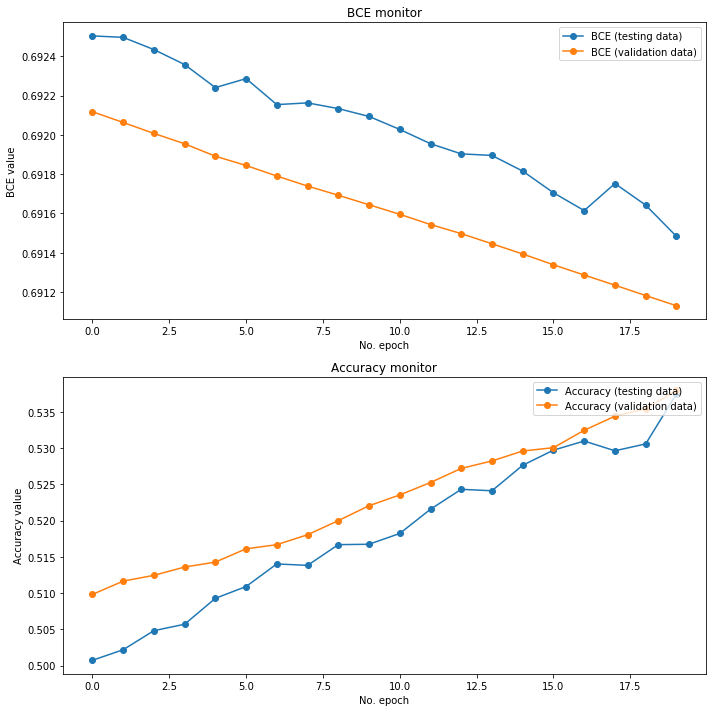

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adam', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_73 (Embedding)        (None, 300, 300)     7365600     input_74[0][0]                   
__________________________________________________________________________________________________
dropout_89 (Dropout)            (None, 300, 300)     0           embedding_73[0][0]               
___________________________________

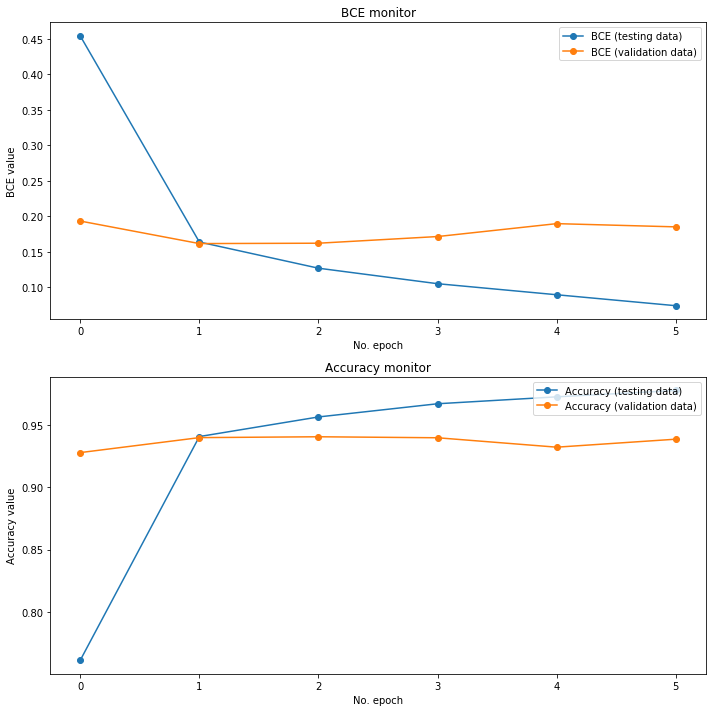

Namespace(activation='relu', dropout=0.3, embedding_dim=300, embedding_matrix=None, epoch=20, learner='adagrad', learning_rate=0.001, max_length=300, model_name='bdlstm_attention', test_batch_size=512, train_batch_size=512, validation_split=0.2, verbose=1)
Model: "model_74"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_74 (Embedding)        (None, 300, 300)     7365600     input_75[0][0]                   
__________________________________________________________________________________________________
dropout_91 (Dropout)            (None, 300, 300)     0           embedding_74[0][0]               
________________________________

Epoch 18/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6919 - binary_accuracy: 0.5334
Epoch 00018: val_loss did not improve from 0.16009
34996/34996 [==============================] - 106s 3ms/sample - loss: 0.6919 - binary_accuracy: 0.5334 - val_loss: 0.6915 - val_binary_accuracy: 0.5279
Epoch 19/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5329
Epoch 00019: val_loss did not improve from 0.16009
34996/34996 [==============================] - 104s 3ms/sample - loss: 0.6918 - binary_accuracy: 0.5331 - val_loss: 0.6914 - val_binary_accuracy: 0.5293
Epoch 20/20
34816/34996 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5372
Epoch 00020: val_loss did not improve from 0.16009
34996/34996 [==============================] - 104s 3ms/sample - loss: 0.6918 - binary_accuracy: 0.5373 - val_loss: 0.6913 - val_binary_accuracy: 0.5307


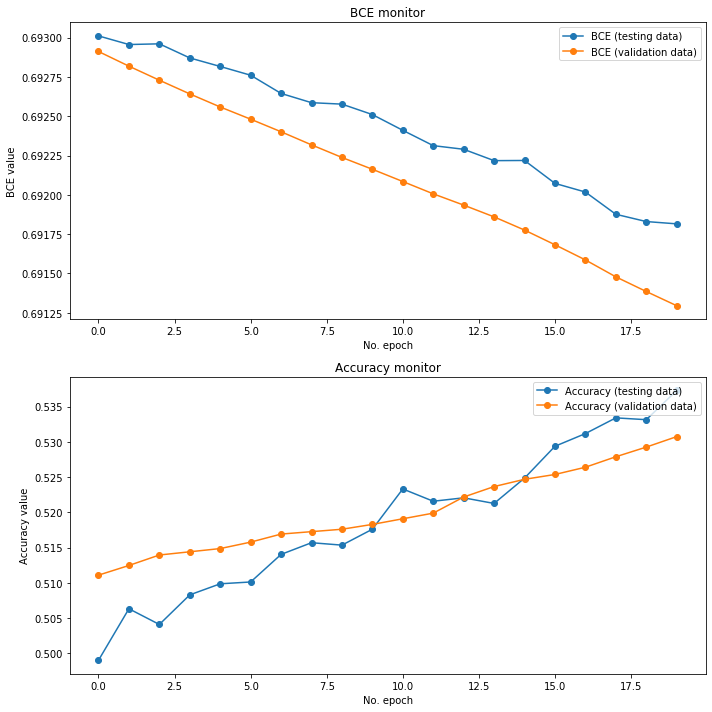

In [57]:
# ====== Experiment Variable ====== #
# name_var1 = 'train_batch_size'
# name_var2 = 'learner'
list_var1 = ['bdlstm_1layer','bdlstm_2layer','bdlstm_conv1d','bdlstm_attention']
list_var2 = [100,200,300] # embedding_dim
list_var3 = [2048,1024,512] # batch_size
list_var4 = ['adam','adagrad'] # learner

# 실험 데이터 생성
with open('experiment.pkl', 'wb') as f:
    pickle.dump(dict(), f)

for var1 in list_var1:
    args.model_name = var1
    for var2 in list_var2:  
        args.embedding_dim = var2
        for var3 in list_var3:
            args.train_batch_size = var3
            for var4 in list_var4:
        #         setattr(args, name_var1, var1)
        #         setattr(args, name_var2, var2)
                args.learner = var4
                print(args)
                model = compile_model(args)
                model.summary()
                history = model.fit(x_train, y_train, 
                      epochs= args.epoch,
                      batch_size=args.train_batch_size,
                      verbose = args.verbose,
                      validation_split = args.validation_split, 
                      callbacks = [earlystop, reduce_lr, cp_callback])
        #         history.history.to_csv('result_{}_{}.csv'.format(var1,var2))
                visualization_training(history)
                with open('./experiment.pkl', 'rb') as f:
                    log_stacking = pickle.load(f)
                log_stacking[str(args)] = history.history
                with open('./experiment.pkl', 'wb') as f:
                    pickle.dump(log_stacking, f)

In [58]:
with open('experiment.pkl','wb') as f:
    final = pickle.load(f)
print(final)

UnsupportedOperation: read

In [ ]:
# 반복문으로 학습시키는 방법
loss, binary_accuracy, val_loss,val_binary_accuracy = [],[],[],[]
# for num in range(args.epoch):
for num in range(2):
    s = time.time()
    history = model.fit(x_train, y_train, 
                  epochs=1,
    #               epochs=args.epoch,
                  batch_size=args.train_batch_size,
                  verbose = args.verbose,
                  validation_split = args.validation_split, 
                  callbacks = [earlystop, reduce_lr, cp_callback])
    loss.append(history.history['loss'])
    binary_accuracy.append(history.history['binary_accuracy'])
    val_loss.append(history.history['val_loss'])
    val_binary_accuracy.append(history.history['val_binary_accuracy'])
    print('1 epoch time = {:.3f}'.format(time.time()-s))

In [ ]:
loss, binary_accuracy, val_loss,val_binary_accuracy

In [ ]:
history.history.keys()

In [ ]:
# def experiment(args):
    
#     return
    
# ====== Experiment Variable ====== #
name_var1 = 'train_batch_size'
name_var2 = 'learner'
list_var1 = [512,1024]
list_var2 = ['adam','adagrad']


for var1 in list_var1:
    args.train_batch_size = var1
    for var2 in list_var2:
#         setattr(args, name_var1, var1)
#         setattr(args, name_var2, var2)
        args.learner = var2
        print(args)
                
#         setting, result = experiment(partition, deepcopy(args))
#         save_exp_result(setting, result)
    

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# 2 layer bdlstm
history = bdlstm_model.fit(x_train, y_train, 
              epochs=args.epoch, 
              batch_size=args.train_batch_size, 
              validation_split = args.validation_split, 
              callbacks = [earlystop, reduce_lr, cp_callback])

In [ ]:
# conv1d_model
history = model.fit(x_train, y_train, 
              epochs=args.epoch, 
              batch_size=args.train_batch_size, 
              validation_split = args.validation_split, 
              callbacks = [earlystop, reduce_lr, cp_callback])